In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
## Environment
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/models'):
    main_path = p[:-len('/models')]
sys.path[0] = main_path

import os, gc
from termcolor import colored
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from src import (config, fe, features, feature_selection, preprocess, training)
from src.fe import CreateFeatures

In [3]:
# DATA PREPARATION
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

# Combine train and valid labels
trvl_labels = pd.concat([train_labels, valid_labels], axis = 0)

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Define SAM testbed files
sam_files = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['features_path']
sam_files = sam_files.to_dict()

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(f'Targets: {target_labels_list}')

# SAM testbed labels
sam_labels = train_labels.drop(train_labels.tail(len(sam_files)).index)
sam_labels = pd.concat([sam_labels, valid_labels], axis=0)
print(f'Labels w/o SAM : {sam_labels.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)
Targets: ['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']
Labels w/o SAM : (1047, 11)


In [4]:
FTS_NAME = 'fts_mra_tempmz_cntpk_mratt_slope_spectra'   # Name of the file with features
COMPUTE_FTS = True                                      # Should the features be recomputed or combined
COMPUTE_FTS_SAM = False                                  # Compute SAM test bed
MODEL_ALGO = 'XGB_opt'                                  # Name of the classifier
MODEL_NAME = FTS_NAME + '_' + MODEL_ALGO                # Name of the model
COMBINE_FTS = ['fts_mra_tempmz_cntpk_mratt_slope', 'fts_mz_spectra']
FTS_SELECT = True

**COMPUTE FEATURES**

- Change the `fe._` method depending on the feature that we wish to calculate

In [5]:
# Check if feature is computed and load it or choose to compute it
check_file = 0
for i in ['_tr', '_trvl', '_vlte']:
    check_file += os.path.exists(os.path.join(config.DATA_DIR_OUT, FTS_NAME +
                                              str(i) + '.csv'))

if (check_file == 3) & (not COMPUTE_FTS):
    print('Reading features ... ')
    X_tr = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_tr.csv'))
    print(X_tr.shape)
    X_trvl = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_trvl.csv'))
    print(X_trvl.shape)
    X_vlte = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_vlte.csv'))
    print(X_vlte.shape)
    
else:
    print('Computing features ... ')
    # ----- TRAIN -----
    fe = CreateFeatures(metadata, train_files, 'tr', FTS_NAME)
    X_tr = fe.combine_features(COMBINE_FTS)
    print(colored(f'train => {X_tr.shape}', 'blue'))
    
    # ----- TRAIN & VALID -----
    fe = CreateFeatures(metadata, trva_files, 'trvl', FTS_NAME)
    X_trvl = fe.combine_features(COMBINE_FTS)
    print(colored(f'train => {X_trvl.shape}', 'blue'))
    
    # ----- VALID & TEST -----
    fe = CreateFeatures(metadata, all_test_files, 'vlte', FTS_NAME)
    X_vlte = fe.combine_features(COMBINE_FTS)
    print(colored(f'train => {X_vlte.shape}', 'blue'))
    
if COMPUTE_FTS_SAM:
    print(f'\nCreating SAM testbed samples ...')
    # Training without SAM testbed
    X_tr_sam = X_tr.drop(X_tr.tail(len(sam_files)).index).copy()
    X_tr_sam = pd.concat([X_tr_sam, X_trvl.iloc[len(train_files):,:]], axis=0)
    print(f'Train shape: {X_tr_sam.shape}')
    # Validation data
    X_vl_sam = X_tr.tail(len(sam_files)).copy()
    print(f'Valid shape: {X_vl_sam.shape}')

Computing features ... 
train => (766, 1991)
train => (1059, 1991)
train => (804, 1991)


## MODELS

**TRAIN**

In [12]:
if FTS_SELECT:
    _, SFM_COLUMNS = feature_selection.fts_select(
        target_labels_list, FTS_NAME, MODEL_NAME, MODEL_ALGO, 'tr',
        X_tr, X_vlte, train_labels, valid_files, valid_labels
    )
else:
    SFM_COLUMNS = None

../models/fts_mra_tempmz_cntpk_mratt_slope_spectra_XGB_opt_tr_sfmt.csv
Computing thresholds ...


  0%|          | 0/10 [00:00<?, ?it/s]

LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.13630146995097805


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.13277193024371506


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.12755466739324464


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.12990890907079186


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.14410739433343772


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.1322224859502675


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.13081326952192984


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.15592940432121247


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.16927304902271315
Threshold=0.009000000000000001, n=766, log-loss: 0.1710878635574698


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.18802972611615199


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.18802972611615199
Threshold=0.012, n=766, log-loss: 0.18720358677737656


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.013000000000000001, n=766, log-loss: 0.2151248791936861
Threshold=0.014, n=766, log-loss: 0.24873719379979697


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.24873719379979697
Threshold=0.016, n=766, log-loss: 0.24873719379979697


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.017, n=766, log-loss: 0.2492378957652242
Threshold=0.018000000000000002, n=766, log-loss: 0.23799071611626765


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.019, n=766, log-loss: 0.23369887033032424
Threshold=0.02, n=766, log-loss: 0.23369887033032424


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.021, n=766, log-loss: 0.24054050784949021
Threshold=0.022, n=766, log-loss: 0.24054050784949021


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.023, n=766, log-loss: 0.3128513876657056
Threshold=0.024, n=766, log-loss: 0.3243932630707837


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.025, n=766, log-loss: 0.3243932630707837
Threshold=0.026000000000000002, n=766, log-loss: 0.3243932630707837


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.027, n=766, log-loss: 0.3243932630707837
Threshold=0.028, n=766, log-loss: 0.3243932630707837


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.029, n=766, log-loss: 0.30076853465606734
Threshold=0.03, n=766, log-loss: 0.30076853465606734


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 10%|█         | 1/10 [00:11<01:46, 11.88s/it]

Threshold=0.031, n=766, log-loss: 0.30076853465606734
Threshold=0.032, n=766, log-loss: 0.30076853465606734
LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.11408863208572931


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.11100018185459287


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.12528527043871074


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.12576882981432208


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.12831645340316233


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.13600814307097397


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.1508292488802666
Threshold=0.007, n=766, log-loss: 0.16456372335747063

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Threshold=0.008, n=766, log-loss: 0.19191997958909016
Threshold=0.009000000000000001, n=766, log-loss: 0.16840681377595684


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.01, n=766, log-loss: 0.17514795086321933
Threshold=0.011, n=766, log-loss: 0.17931627916408951


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.17643945318219212
Threshold=0.013000000000000001, n=766, log-loss: 0.231659328500834


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.231659328500834
Threshold=0.015, n=766, log-loss: 0.22301266596786862


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.22301266596786862
Threshold=0.017, n=766, log-loss: 0.23372540208860698


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.2427214827084971
Threshold=0.019, n=766, log-loss: 0.2427214827084971


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.2427214827084971
Threshold=0.021, n=766, log-loss: 0.2427214827084971


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.2705822843701083
Threshold=0.023, n=766, log-loss: 0.2705822843701083


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.2841622120626875
Threshold=0.025, n=766, log-loss: 0.2841622120626875


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.2841622120626875
Threshold=0.027, n=766, log-loss: 0.28773940737087456


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.31407814080359686
Threshold=0.029, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.03, n=766, log-loss: 0.31407814080359686
Threshold=0.031, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.032, n=766, log-loss: 0.31407814080359686
Threshold=0.033, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.034, n=766, log-loss: 0.31407814080359686
Threshold=0.035, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.036000000000000004, n=766, log-loss: 0.31407814080359686
Threshold=0.037, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.038, n=766, log-loss: 0.31407814080359686
Threshold=0.039, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.04, n=766, log-loss: 0.31407814080359686
Threshold=0.041, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.042, n=766, log-loss: 0.31407814080359686
Threshold=0.043000000000000003, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.044, n=766, log-loss: 0.31407814080359686
Threshold=0.045, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.046, n=766, log-loss: 0.31407814080359686
Threshold=0.047, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.048, n=766, log-loss: 0.31407814080359686
Threshold=0.049, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.05, n=766, log-loss: 0.31407814080359686
Threshold=0.051000000000000004, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.052000000000000005, n=766, log-loss: 0.31407814080359686
Threshold=0.053, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.054, n=766, log-loss: 0.31407814080359686
Threshold=0.055, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.056, n=766, log-loss: 0.31407814080359686
Threshold=0.057, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.058, n=766, log-loss: 0.31407814080359686
Threshold=0.059000000000000004, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.06, n=766, log-loss: 0.31407814080359686
Threshold=0.061, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.062, n=766, log-loss: 0.31407814080359686
Threshold=0.063, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.064, n=766, log-loss: 0.31407814080359686
Threshold=0.065, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.066, n=766, log-loss: 0.31407814080359686
Threshold=0.067, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.068, n=766, log-loss: 0.31407814080359686
Threshold=0.069, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.07, n=766, log-loss: 0.31407814080359686
Threshold=0.07100000000000001, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.07200000000000001, n=766, log-loss: 0.31407814080359686
Threshold=0.073, n=766, log-loss: 0.31407814080359686


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 20%|

Threshold=0.074, n=766, log-loss: 0.31407814080359686
Threshold=0.075, n=766, log-loss: 0.31407814080359686
LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.192937556498862


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.1950815626737541


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.17632254958927548


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.17482830778140981


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.2147035336280051


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.18192865660909957


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.175376142346564


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.18929937127806762
Threshold=0.008, n=766, log-loss: 0.17862736719498354


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.22515875277619604
Threshold=0.01, n=766, log-loss: 0.2243744365202657


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.22738053052429485
Threshold=0.012, n=766, log-loss: 0.28096983979659557


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.013000000000000001, n=766, log-loss: 0.2710764920640953
Threshold=0.014, n=766, log-loss: 0.3195719266975451


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.3195719266975451
Threshold=0.016, n=766, log-loss: 0.3437056147442565


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.017, n=766, log-loss: 0.3634779267521645
Threshold=0.018000000000000002, n=766, log-loss: 0.3634779267521645


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.019, n=766, log-loss: 0.400785728367268
Threshold=0.02, n=766, log-loss: 0.400785728367268


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.021, n=766, log-loss: 0.426579444011222
Threshold=0.022, n=766, log-loss: 0.426579444011222


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 30%|███       | 3/10 [00:39<01:30, 12.96s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.023, n=766, log-loss: 0.426579444011222
LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.28392033908816544


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.2888463412438529


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.27891858436052813


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.3101679083246359


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.32703263262734167


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.33477671281593524


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.31615830318995913


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.32659215035287303
Threshold=0.008, n=766, log-loss: 0.30707898858295746
Threshold=0.009000000000000001, n=766, log-loss: 0.3217507525686486


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.01, n=766, log-loss: 0.31796293431192113
Threshold=0.011, n=766, log-loss: 0.3204719003706331


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.3204719003706331
Threshold=0.013000000000000001, n=766, log-loss: 0.3342118385198618


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.3342118385198618
Threshold=0.015, n=766, log-loss: 0.36272385265239526


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.38022249148294024
Threshold=0.017, n=766, log-loss: 0.431858553532066


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.5382782964627084
Threshold=0.019, n=766, log-loss: 0.5382782964627084


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.5382782964627084
Threshold=0.021, n=766, log-loss: 0.5382782964627084


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.5382782964627084
Threshold=0.023, n=766, log-loss: 0.5382782964627084


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.5382782964627084
Threshold=0.025, n=766, log-loss: 0.5382782964627084


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.5382782964627084
Threshold=0.027, n=766, log-loss: 0.5382782964627084


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 40%|████      | 4/10 [00:52<01:17, 12.85s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.5382782964627084
Threshold=0.029, n=766, log-loss: 0.5382782964627084
LABEL: oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.01656130027882564
Threshold=0.001, n=766, log-loss: 0.01656130027882564
Threshold=0.002, n=766, log-loss: 0.01656130027882564


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.01656130027882564
Threshold=0.004, n=766, log-loss: 0.01656130027882564
Threshold=0.005, n=766, log-loss: 0.01656130027882564


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.01656130027882564
Threshold=0.007, n=766, log-loss: 0.01656130027882564
Threshold=0.008, n=766, log-loss: 0.01656130027882564


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.009000000000000001, n=766, log-loss: 0.01656130027882564
Threshold=0.01, n=766, log-loss: 0.01656130027882564


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.01673554649986581
Threshold=0.012, n=766, log-loss: 0.016728836996162965
Threshold=0.013000000000000001, n=766, log-loss: 0.016728836996162965


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.016726124324277995
Threshold=0.015, n=766, log-loss: 0.016726124324277995
Threshold=0.016, n=766, log-loss: 0.016726124324277995


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.017, n=766, log-loss: 0.01696144233266235
Threshold=0.018000000000000002, n=766, log-loss: 0.01704260657673365
Threshold=0.019, n=766, log-loss: 0.017851925719848838


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.01813087545402043
Threshold=0.021, n=766, log-loss: 0.01813087545402043
Threshold=0.022, n=766, log-loss: 0.01813087545402043


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.023, n=766, log-loss: 0.018121229270123478
Threshold=0.024, n=766, log-loss: 0.018121229270123478
Threshold=0.025, n=766, log-loss: 0.018121229270123478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.026000000000000002, n=766, log-loss: 0.018834628229730352
Threshold=0.027, n=766, log-loss: 0.018834628229730352
Threshold=0.028, n=766, log-loss: 0.018834628229730352


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.029, n=766, log-loss: 0.020142026341745927
Threshold=0.03, n=766, log-loss: 0.020142026341745927
Threshold=0.031, n=766, log-loss: 0.020142026341745927


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.032, n=766, log-loss: 0.020142026341745927
Threshold=0.033, n=766, log-loss: 0.019809044660951104
Threshold=0.034, n=766, log-loss: 0.019809044660951104


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.035, n=766, log-loss: 0.019809044660951104
Threshold=0.036000000000000004, n=766, log-loss: 0.019809044660951104
Threshold=0.037, n=766, log-loss: 0.019809044660951104


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.038, n=766, log-loss: 0.019809044660951104
Threshold=0.039, n=766, log-loss: 0.019809044660951104
Threshold=0.04, n=766, log-loss: 0.020003274397816472


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.041, n=766, log-loss: 0.020003274397816472
Threshold=0.042, n=766, log-loss: 0.020003274397816472
Threshold=0.043000000000000003, n=766, log-loss: 0.020003274397816472


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.044, n=766, log-loss: 0.020003274397816472
Threshold=0.045, n=766, log-loss: 0.02208862456023445
Threshold=0.046, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.047, n=766, log-loss: 0.02208862456023445
Threshold=0.048, n=766, log-loss: 0.02208862456023445
Threshold=0.049, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.05, n=766, log-loss: 0.02208862456023445
Threshold=0.051000000000000004, n=766, log-loss: 0.02208862456023445
Threshold=0.052000000000000005, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.053, n=766, log-loss: 0.02208862456023445
Threshold=0.054, n=766, log-loss: 0.02208862456023445
Threshold=0.055, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.056, n=766, log-loss: 0.02208862456023445
Threshold=0.057, n=766, log-loss: 0.02208862456023445
Threshold=0.058, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.059000000000000004, n=766, log-loss: 0.02208862456023445
Threshold=0.06, n=766, log-loss: 0.02208862456023445
Threshold=0.061, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.062, n=766, log-loss: 0.02208862456023445
Threshold=0.063, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.064, n=766, log-loss: 0.02208862456023445
Threshold=0.065, n=766, log-loss: 0.02208862456023445
Threshold=0.066, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.067, n=766, log-loss: 0.02208862456023445
Threshold=0.068, n=766, log-loss: 0.02208862456023445
Threshold=0.069, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.07, n=766, log-loss: 0.02208862456023445
Threshold=0.07100000000000001, n=766, log-loss: 0.02208862456023445
Threshold=0.07200000000000001, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.073, n=766, log-loss: 0.02208862456023445
Threshold=0.074, n=766, log-loss: 0.02208862456023445
Threshold=0.075, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.076, n=766, log-loss: 0.02208862456023445
Threshold=0.077, n=766, log-loss: 0.02208862456023445
Threshold=0.078, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.079, n=766, log-loss: 0.02208862456023445
Threshold=0.08, n=766, log-loss: 0.02208862456023445
Threshold=0.081, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.082, n=766, log-loss: 0.02208862456023445
Threshold=0.083, n=766, log-loss: 0.02208862456023445
Threshold=0.084, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.085, n=766, log-loss: 0.02208862456023445
Threshold=0.08600000000000001, n=766, log-loss: 0.02208862456023445
Threshold=0.08700000000000001, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.088, n=766, log-loss: 0.02208862456023445
Threshold=0.089, n=766, log-loss: 0.02208862456023445
Threshold=0.09, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.091, n=766, log-loss: 0.02208862456023445
Threshold=0.092, n=766, log-loss: 0.02208862456023445
Threshold=0.093, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.094, n=766, log-loss: 0.02208862456023445
Threshold=0.095, n=766, log-loss: 0.02208862456023445
Threshold=0.096, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.097, n=766, log-loss: 0.02208862456023445
Threshold=0.098, n=766, log-loss: 0.02208862456023445
Threshold=0.099, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.1, n=766, log-loss: 0.02208862456023445
Threshold=0.101, n=766, log-loss: 0.02208862456023445
Threshold=0.10200000000000001, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.10300000000000001, n=766, log-loss: 0.02208862456023445
Threshold=0.10400000000000001, n=766, log-loss: 0.02208862456023445
Threshold=0.105, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.106, n=766, log-loss: 0.02208862456023445
Threshold=0.107, n=766, log-loss: 0.02208862456023445


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.108, n=766, log-loss: 0.04321876560268707
Threshold=0.109, n=766, log-loss: 0.04321876560268707
Threshold=0.11, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.111, n=766, log-loss: 0.04321876560268707
Threshold=0.112, n=766, log-loss: 0.04321876560268707
Threshold=0.113, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.114, n=766, log-loss: 0.04321876560268707
Threshold=0.115, n=766, log-loss: 0.04321876560268707
Threshold=0.116, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.117, n=766, log-loss: 0.04321876560268707
Threshold=0.11800000000000001, n=766, log-loss: 0.04321876560268707
Threshold=0.11900000000000001, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.12, n=766, log-loss: 0.04321876560268707
Threshold=0.121, n=766, log-loss: 0.04321876560268707
Threshold=0.122, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.123, n=766, log-loss: 0.04321876560268707
Threshold=0.124, n=766, log-loss: 0.04321876560268707
Threshold=0.125, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.126, n=766, log-loss: 0.04321876560268707
Threshold=0.127, n=766, log-loss: 0.04321876560268707
Threshold=0.128, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.129, n=766, log-loss: 0.04321876560268707
Threshold=0.13, n=766, log-loss: 0.04321876560268707
Threshold=0.131, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.132, n=766, log-loss: 0.04321876560268707
Threshold=0.133, n=766, log-loss: 0.04321876560268707
Threshold=0.134, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.135, n=766, log-loss: 0.04321876560268707
Threshold=0.136, n=766, log-loss: 0.04321876560268707
Threshold=0.137, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.138, n=766, log-loss: 0.04321876560268707
Threshold=0.139, n=766, log-loss: 0.04321876560268707
Threshold=0.14, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.14100000000000001, n=766, log-loss: 0.04321876560268707
Threshold=0.14200000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.14300000000000002, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.14400000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.145, n=766, log-loss: 0.04321876560268707
Threshold=0.146, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.147, n=766, log-loss: 0.04321876560268707
Threshold=0.148, n=766, log-loss: 0.04321876560268707
Threshold=0.149, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.15, n=766, log-loss: 0.04321876560268707
Threshold=0.151, n=766, log-loss: 0.04321876560268707
Threshold=0.152, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.153, n=766, log-loss: 0.04321876560268707
Threshold=0.154, n=766, log-loss: 0.04321876560268707
Threshold=0.155, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.156, n=766, log-loss: 0.04321876560268707
Threshold=0.157, n=766, log-loss: 0.04321876560268707
Threshold=0.158, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.159, n=766, log-loss: 0.04321876560268707
Threshold=0.16, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.161, n=766, log-loss: 0.04321876560268707
Threshold=0.162, n=766, log-loss: 0.04321876560268707
Threshold=0.163, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.164, n=766, log-loss: 0.04321876560268707
Threshold=0.165, n=766, log-loss: 0.04321876560268707
Threshold=0.166, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.167, n=766, log-loss: 0.04321876560268707
Threshold=0.168, n=766, log-loss: 0.04321876560268707
Threshold=0.169, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.17, n=766, log-loss: 0.04321876560268707
Threshold=0.171, n=766, log-loss: 0.04321876560268707
Threshold=0.17200000000000001, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.17300000000000001, n=766, log-loss: 0.04321876560268707
Threshold=0.17400000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.17500000000000002, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.176, n=766, log-loss: 0.04321876560268707
Threshold=0.177, n=766, log-loss: 0.04321876560268707
Threshold=0.178, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.179, n=766, log-loss: 0.04321876560268707
Threshold=0.18, n=766, log-loss: 0.04321876560268707
Threshold=0.181, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.182, n=766, log-loss: 0.04321876560268707
Threshold=0.183, n=766, log-loss: 0.04321876560268707
Threshold=0.184, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.185, n=766, log-loss: 0.04321876560268707
Threshold=0.186, n=766, log-loss: 0.04321876560268707
Threshold=0.187, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.188, n=766, log-loss: 0.04321876560268707
Threshold=0.189, n=766, log-loss: 0.04321876560268707
Threshold=0.19, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.191, n=766, log-loss: 0.04321876560268707
Threshold=0.192, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.193, n=766, log-loss: 0.04321876560268707
Threshold=0.194, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.195, n=766, log-loss: 0.04321876560268707
Threshold=0.196, n=766, log-loss: 0.04321876560268707
Threshold=0.197, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.198, n=766, log-loss: 0.04321876560268707
Threshold=0.199, n=766, log-loss: 0.04321876560268707
Threshold=0.2, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.201, n=766, log-loss: 0.04321876560268707
Threshold=0.202, n=766, log-loss: 0.04321876560268707
Threshold=0.203, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.20400000000000001, n=766, log-loss: 0.04321876560268707
Threshold=0.20500000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.20600000000000002, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.20700000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.20800000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.209, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.21, n=766, log-loss: 0.04321876560268707
Threshold=0.211, n=766, log-loss: 0.04321876560268707
Threshold=0.212, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.213, n=766, log-loss: 0.04321876560268707
Threshold=0.214, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.215, n=766, log-loss: 0.04321876560268707
Threshold=0.216, n=766, log-loss: 0.04321876560268707
Threshold=0.217, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.218, n=766, log-loss: 0.04321876560268707
Threshold=0.219, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.22, n=766, log-loss: 0.04321876560268707
Threshold=0.221, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.222, n=766, log-loss: 0.04321876560268707
Threshold=0.223, n=766, log-loss: 0.04321876560268707
Threshold=0.224, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.225, n=766, log-loss: 0.04321876560268707
Threshold=0.226, n=766, log-loss: 0.04321876560268707
Threshold=0.227, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.228, n=766, log-loss: 0.04321876560268707
Threshold=0.229, n=766, log-loss: 0.04321876560268707
Threshold=0.23, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.231, n=766, log-loss: 0.04321876560268707
Threshold=0.232, n=766, log-loss: 0.04321876560268707
Threshold=0.233, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.234, n=766, log-loss: 0.04321876560268707
Threshold=0.23500000000000001, n=766, log-loss: 0.04321876560268707
Threshold=0.23600000000000002, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.23700000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.23800000000000002, n=766, log-loss: 0.04321876560268707
Threshold=0.23900000000000002, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.24, n=766, log-loss: 0.04321876560268707
Threshold=0.241, n=766, log-loss: 0.04321876560268707
Threshold=0.242, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.243, n=766, log-loss: 0.04321876560268707
Threshold=0.244, n=766, log-loss: 0.04321876560268707
Threshold=0.245, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.246, n=766, log-loss: 0.04321876560268707
Threshold=0.247, n=766, log-loss: 0.04321876560268707
Threshold=0.248, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.249, n=766, log-loss: 0.04321876560268707
Threshold=0.25, n=766, log-loss: 0.04321876560268707
Threshold=0.251, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.252, n=766, log-loss: 0.04321876560268707
Threshold=0.253, n=766, log-loss: 0.04321876560268707
Threshold=0.254, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.255, n=766, log-loss: 0.04321876560268707
Threshold=0.256, n=766, log-loss: 0.04321876560268707
Threshold=0.257, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.258, n=766, log-loss: 0.04321876560268707
Threshold=0.259, n=766, log-loss: 0.04321876560268707
Threshold=0.26, n=766, log-loss: 0.04321876560268707


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.261, n=766, log-loss: 0.04321876560268707
Threshold=0.262, n=766, log-loss: 0.05803098899682622
Threshold=0.263, n=766, log-loss: 0.05803098899682622


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.264, n=766, log-loss: 0.05803098899682622
Threshold=0.265, n=766, log-loss: 0.05803098899682622
Threshold=0.266, n=766, log-loss: 0.05803098899682622


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.267, n=766, log-loss: 0.05803098899682622
Threshold=0.268, n=766, log-loss: 0.05803098899682622
Threshold=0.269, n=766, log-loss: 0.05803098899682622


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.27, n=766, log-loss: 0.05803098899682622
Threshold=0.271, n=766, log-loss: 0.05803098899682622
Threshold=0.272, n=766, log-loss: 0.05803098899682622


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.273, n=766, log-loss: 0.05803098899682622
Threshold=0.274, n=766, log-loss: 0.05803098899682622
Threshold=0.275, n=766, log-loss: 0.05803098899682622


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.276, n=766, log-loss: 0.05803098899682622
Threshold=0.277, n=766, log-loss: 0.05803098899682622
Threshold=0.278, n=766, log-loss: 0.05803098899682622


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.279, n=766, log-loss: 0.05803098899682622
Threshold=0.28, n=766, log-loss: 0.05803098899682622


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 50%|

Threshold=0.281, n=766, log-loss: 0.05803098899682622
Threshold=0.28200000000000003, n=766, log-loss: 0.05803098899682622
Threshold=0.28300000000000003, n=766, log-loss: 0.05803098899682622
LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.14497248129760243


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.15097983393110112


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.15016938659716905


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.17643239639807531


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.16817824727614847


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.1850588264852864


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.1779672430713785


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.1728388063375975


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.18883146476930282


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.18438290534167529


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.1904945168123698


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.011, n=766, log-loss: 0.20065576040683436
Threshold=0.012, n=766, log-loss: 0.27483192309872295


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.013000000000000001, n=766, log-loss: 0.266312917095288
Threshold=0.014, n=766, log-loss: 0.2716659913745426

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Threshold=0.015, n=766, log-loss: 0.2716659913745426


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.016, n=766, log-loss: 0.29397517072319757
Threshold=0.017, n=766, log-loss: 0.29397517072319757


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.29397517072319757
Threshold=0.019, n=766, log-loss: 0.29397517072319757


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.29397517072319757
Threshold=0.021, n=766, log-loss: 0.29397517072319757


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.29397517072319757
Threshold=0.023, n=766, log-loss: 0.29397517072319757


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.29397517072319757
Threshold=0.025, n=766, log-loss: 0.29397517072319757


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.32233861959126137
Threshold=0.027, n=766, log-loss: 0.32233861959126137


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.32233861959126137
Threshold=0.029, n=766, log-loss: 0.4349315210226478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.03, n=766, log-loss: 0.4349315210226478
Threshold=0.031, n=766, log-loss: 0.4349315210226478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.032, n=766, log-loss: 0.4349315210226478
Threshold=0.033, n=766, log-loss: 0.4349315210226478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.034, n=766, log-loss: 0.4349315210226478
Threshold=0.035, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.036000000000000004, n=766, log-loss: 0.557234230225607
Threshold=0.037, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.038, n=766, log-loss: 0.557234230225607
Threshold=0.039, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.04, n=766, log-loss: 0.557234230225607
Threshold=0.041, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.042, n=766, log-loss: 0.557234230225607
Threshold=0.043000000000000003, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.044, n=766, log-loss: 0.557234230225607
Threshold=0.045, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.046, n=766, log-loss: 0.557234230225607
Threshold=0.047, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.048, n=766, log-loss: 0.557234230225607
Threshold=0.049, n=766, log-loss: 0.557234230225607


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 60%|██████    | 6/10 [01:35<01:10, 17.52s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.05, n=766, log-loss: 0.557234230225607
LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.2335698383342977


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.24126883546278236


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.23910723717441407


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.2521599480940296


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.2881357766538477


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.2914388445698666


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.2741051618170324


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.28572711230926345


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.2957453307037722


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.31938428970756255


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.31938428970756255
Threshold=0.011, n=766, log-loss: 0.3154444064430053


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.3154444064430053
Threshold=0.013000000000000001, n=766, log-loss: 0.3308010234262273


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.32454931299574036
Threshold=0.015, n=766, log-loss: 0.3339594489093806


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.36003822233423005
Threshold=0.017, n=766, log-loss: 0.36003822233423005


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.3941981374570598
Threshold=0.019, n=766, log-loss: 0.3941981374570598


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.3941981374570598
Threshold=0.021, n=766, log-loss: 0.3941981374570598


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.3941981374570598
Threshold=0.023, n=766, log-loss: 0.3941981374570598


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.3941981374570598
Threshold=0.025, n=766, log-loss: 0.3941981374570598


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.3941981374570598
Threshold=0.027, n=766, log-loss: 0.3941981374570598


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.3941981374570598
Threshold=0.029, n=766, log-loss: 0.3941981374570598


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.03, n=766, log-loss: 0.39639998765808526
Threshold=0.031, n=766, log-loss: 0.4658431291116128


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.032, n=766, log-loss: 0.4658431291116128
Threshold=0.033, n=766, log-loss: 0.6836157831976845


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.034, n=766, log-loss: 0.6836157831976845
Threshold=0.035, n=766, log-loss: 0.6836157831976845


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.036000000000000004, n=766, log-loss: 0.6836157831976845


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.037, n=766, log-loss: 0.6836157831976845
Threshold=0.038, n=766, log-loss: 0.6836157831976845


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 70%|███████   | 7/10 [01:49<00:49, 16.39s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.039, n=766, log-loss: 0.6836157831976845
Threshold=0.04, n=766, log-loss: 0.6836157831976845
LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.16933459650630564


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.16731749935418927


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.18079636169541086


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.19497257689770578


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.18340580628504627


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.20544947628404647


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.21466901762718527


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.22704200702302202


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.2362019525840481


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.24644042812677183


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.2696100233796962
Threshold=0.011, n=766, log-loss: 0.2677156819509813


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.28546382285258814
Threshold=0.013000000000000001, n=766, log-loss: 0.284969199922829


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.284969199922829


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.015, n=766, log-loss: 0.2618605045708208
Threshold=0.016, n=766, log-loss: 0.300171179749364


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/User

Threshold=0.017, n=766, log-loss: 0.300171179749364
Threshold=0.018000000000000002, n=766, log-loss: 0.35329040228119024


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.019, n=766, log-loss: 0.35329040228119024


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.35329040228119024
Threshold=0.021, n=766, log-loss: 0.35329040228119024


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.355993465550638
Threshold=0.023, n=766, log-loss: 0.37585891239701075


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 80%|████████  | 8/10 [02:01<00:29, 14.84s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.37585891239701075
LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.22810508353308276


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.21824031680386907


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.23024991345226306


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.23040155020944533


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.24057771500542524


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.24909378960212128


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.27591959258609805


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.24506094383430244


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.2820279951423483


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.3410648763622396


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.3303355913308891
Threshold=0.011, n=766, log-loss: 0.3303355913308891


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.32376469137606373
Threshold=0.013000000000000001, n=766, log-loss: 0.32952997393575545


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.32952997393575545
Threshold=0.015, n=766, log-loss: 0.37500691800712016


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.37500691800712016
Threshold=0.017, n=766, log-loss: 0.37500691800712016


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.37500691800712016
Threshold=0.019, n=766, log-loss: 0.3973133512248155


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.4165252359177116
Threshold=0.021, n=766, log-loss: 0.46257308474344555


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.4829382421607756
Threshold=0.023, n=766, log-loss: 0.4829382421607756


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.4829382421607756
Threshold=0.025, n=766, log-loss: 0.4829382421607756


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.4829382421607756
Threshold=0.027, n=766, log-loss: 0.4829382421607756


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.4829382421607756
Threshold=0.029, n=766, log-loss: 0.4829382421607756


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.03, n=766, log-loss: 0.4829382421607756
Threshold=0.031, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.032, n=766, log-loss: 0.4711669226250144
Threshold=0.033, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.034, n=766, log-loss: 0.4711669226250144
Threshold=0.035, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.036000000000000004, n=766, log-loss: 0.4711669226250144
Threshold=0.037, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.038, n=766, log-loss: 0.4711669226250144
Threshold=0.039, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.04, n=766, log-loss: 0.4711669226250144
Threshold=0.041, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.042, n=766, log-loss: 0.4711669226250144
Threshold=0.043000000000000003, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.044, n=766, log-loss: 0.4711669226250144
Threshold=0.045, n=766, log-loss: 0.4711669226250144


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 90%|█████████ | 9/10 [02:15<00:14, 14.69s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.046, n=766, log-loss: 0.4711669226250144
LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.0, n=766, log-loss: 0.06540122062842753


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.001, n=766, log-loss: 0.0668845066543249


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.002, n=766, log-loss: 0.06680032471780913


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.003, n=766, log-loss: 0.06810253982401593


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.004, n=766, log-loss: 0.06740688571766808


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.005, n=766, log-loss: 0.06790045976822356


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.006, n=766, log-loss: 0.07224475409507389


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.007, n=766, log-loss: 0.0730857464618768


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.008, n=766, log-loss: 0.06451768592677838


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.009000000000000001, n=766, log-loss: 0.07327192000964888


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.01, n=766, log-loss: 0.07291037401994181
Threshold=0.011, n=766, log-loss: 0.07448610733958508


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.012, n=766, log-loss: 0.0750312292409994
Threshold=0.013000000000000001, n=766, log-loss: 0.0809777329233634


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.014, n=766, log-loss: 0.09963359342889587
Threshold=0.015, n=766, log-loss: 0.10163594326524877


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.016, n=766, log-loss: 0.0876330508949448
Threshold=0.017, n=766, log-loss: 0.0876330508949448


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.018000000000000002, n=766, log-loss: 0.0922452249395766
Threshold=0.019, n=766, log-loss: 0.08769800877651523


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.02, n=766, log-loss: 0.08006674327681781
Threshold=0.021, n=766, log-loss: 0.07933237487327072


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.022, n=766, log-loss: 0.0728766146360709
Threshold=0.023, n=766, log-loss: 0.0728766146360709


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.024, n=766, log-loss: 0.07775630705664888
Threshold=0.025, n=766, log-loss: 0.08771539068802295


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.026000000000000002, n=766, log-loss: 0.08771539068802295
Threshold=0.027, n=766, log-loss: 0.08771539068802295


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.028, n=766, log-loss: 0.08771539068802295
Threshold=0.029, n=766, log-loss: 0.08771539068802295


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.03, n=766, log-loss: 0.08771539068802295
Threshold=0.031, n=766, log-loss: 0.08771539068802295


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.032, n=766, log-loss: 0.09673423078523015


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.033, n=766, log-loss: 0.09673423078523015
Threshold=0.034, n=766, log-loss: 0.0998250002958478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.035, n=766, log-loss: 0.0998250002958478
Threshold=0.036000000000000004, n=766, log-loss: 0.0998250002958478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.037, n=766, log-loss: 0.0998250002958478
Threshold=0.038, n=766, log-loss: 0.0998250002958478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.039, n=766, log-loss: 0.0998250002958478
Threshold=0.04, n=766, log-loss: 0.0998250002958478


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Threshold=0.041, n=766, log-loss: 0.13033374365651185
Threshold=0.042, n=766, log-loss: 0.13033374365651185


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
100%|██████████| 10/10 [02:28<00:00, 14.84s/it]


Threshold=0.043000000000000003, n=766, log-loss: 0.13033374365651185
Computing columns ...


  0%|          | 0/10 [00:00<?, ?it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 10%|█         | 1/10 [00:00<00:06,  1.33it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=143, log-loss: 0.12755466739324464
LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 20%|██        | 2/10 [00:01<00:07,  1.05it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=220, log-loss: 0.11100018185459287
LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 30%|███       | 3/10 [00:02<00:05,  1.32it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=108, log-loss: 0.17482830778140981
LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 40%|████      | 4/10 [00:03<00:04,  1.36it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=159, log-loss: 0.27891858436052813
LABEL: oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 50%|█████     | 5/10 [00:05<00:05,  1.20s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=1991, log-loss: 0.01656130027882564
LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 60%|██████    | 6/10 [00:10<00:10,  2.52s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=1991, log-loss: 0.14497248129760243
LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 70%|███████   | 7/10 [00:16<00:10,  3.65s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=1991, log-loss: 0.2335698383342977
LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 80%|████████  | 8/10 [00:17<00:05,  2.86s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=263, log-loss: 0.16731749935418927
LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
 90%|█████████ | 9/10 [00:18<00:02,  2.26s/it]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


N=231, log-loss: 0.21824031680386907
LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
100%|██████████| 10/10 [00:18<00:00,  1.85s/it]

N=41, log-loss: 0.06451768592677838


In [13]:
for label in target_labels_list:
    print(f'{label}: {len(SFM_COLUMNS[label])}')

basalt: 143
carbonate: 220
chloride: 108
iron_oxide: 159
oxalate: 1991
oxychlorine: 1991
phyllosilicate: 1991
silicate: 263
sulfate: 231
sulfide: 41


CV training ....
basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

Full training .....
LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


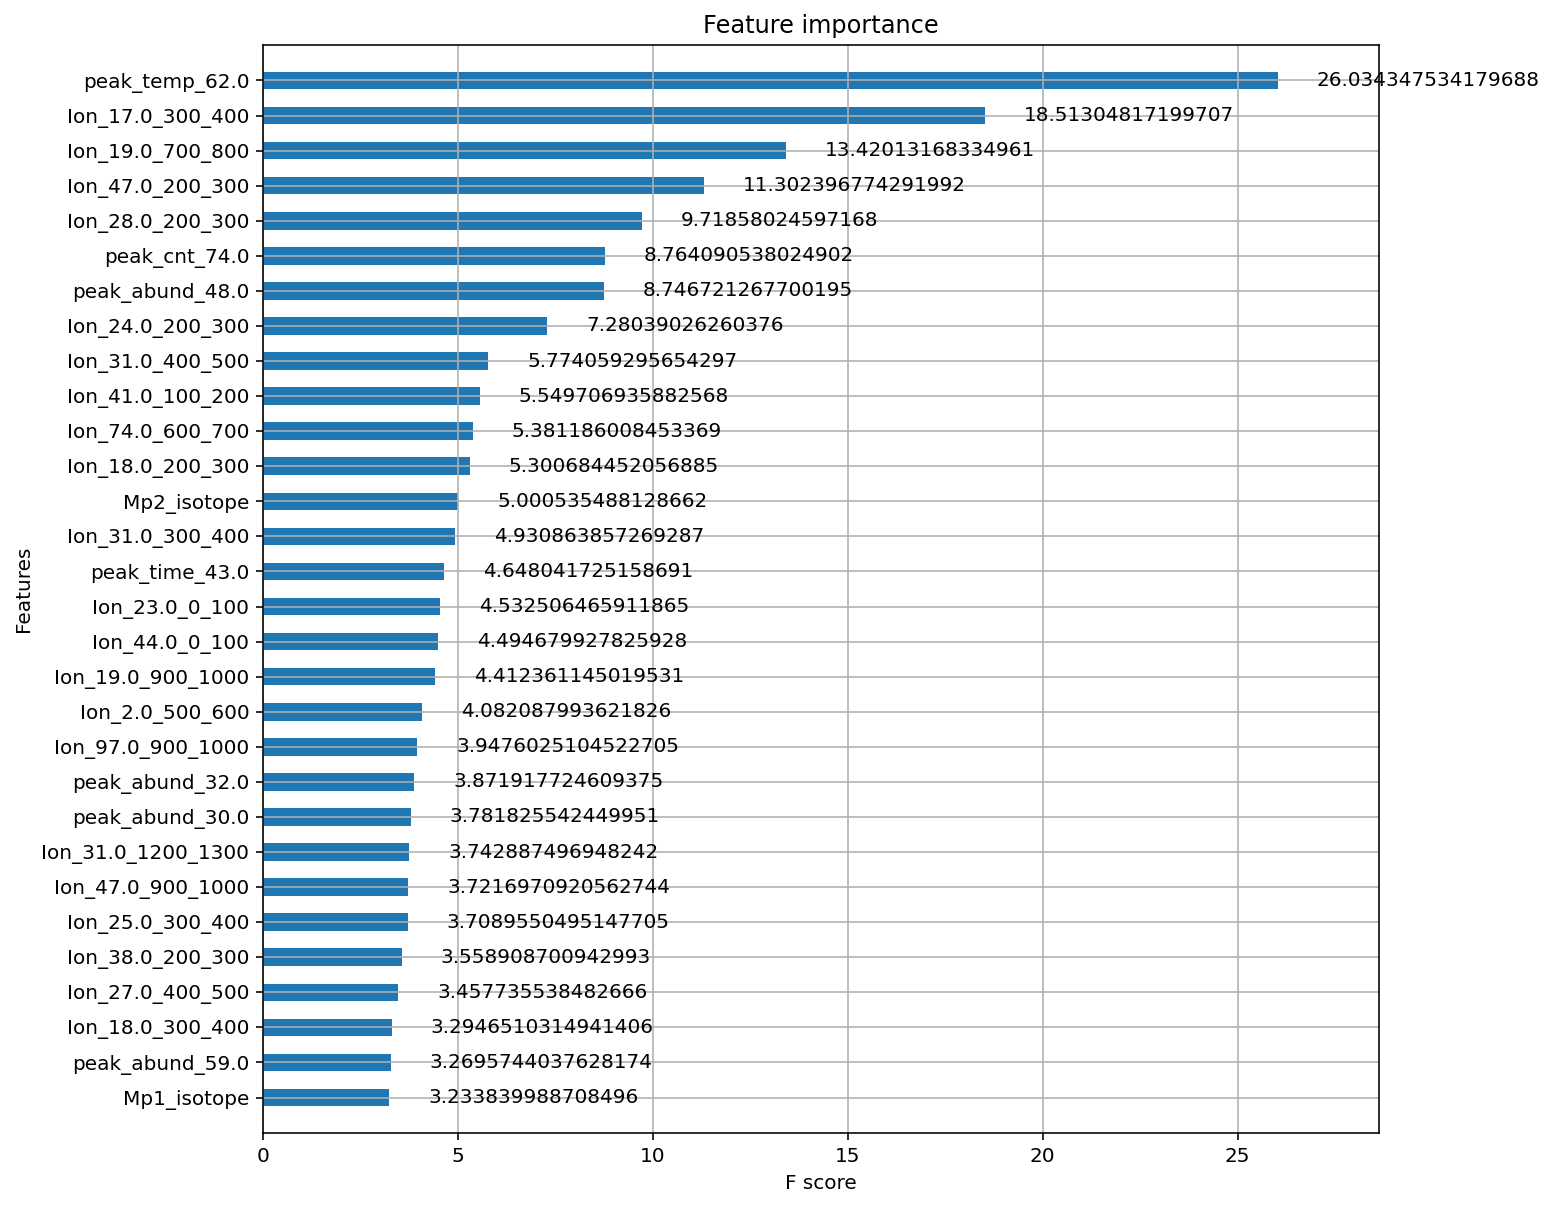

LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


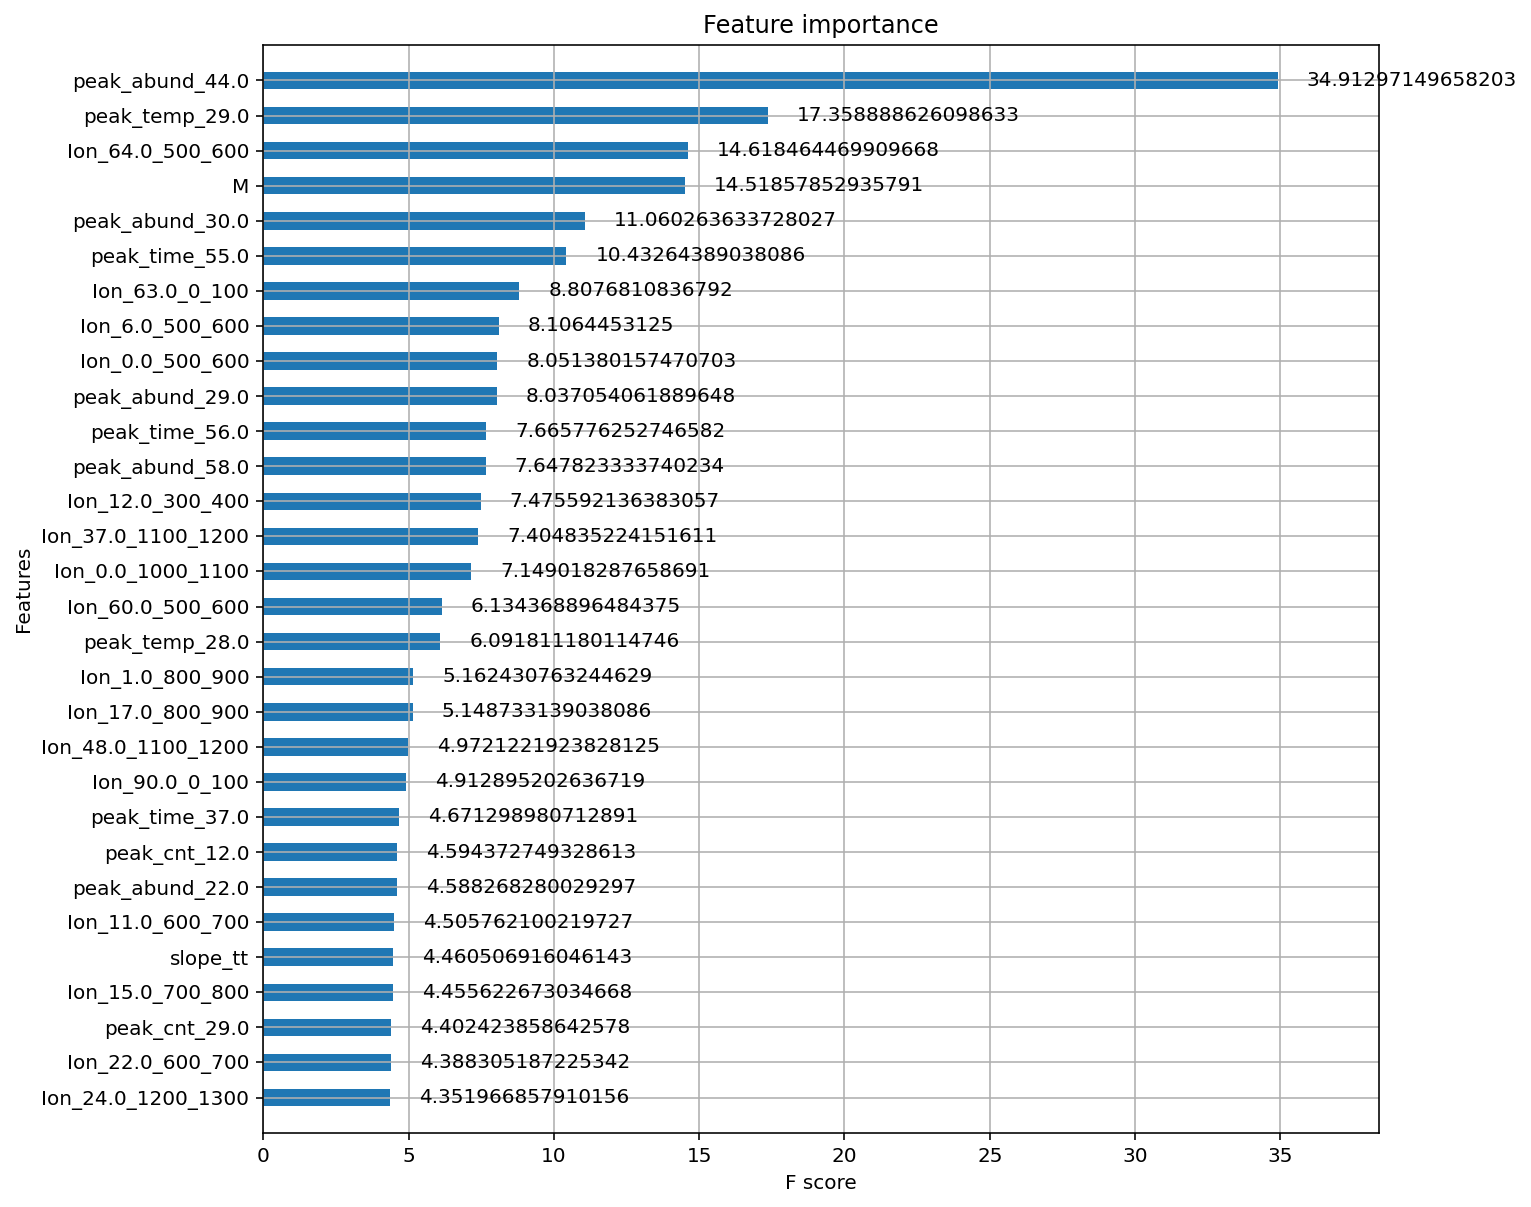

LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


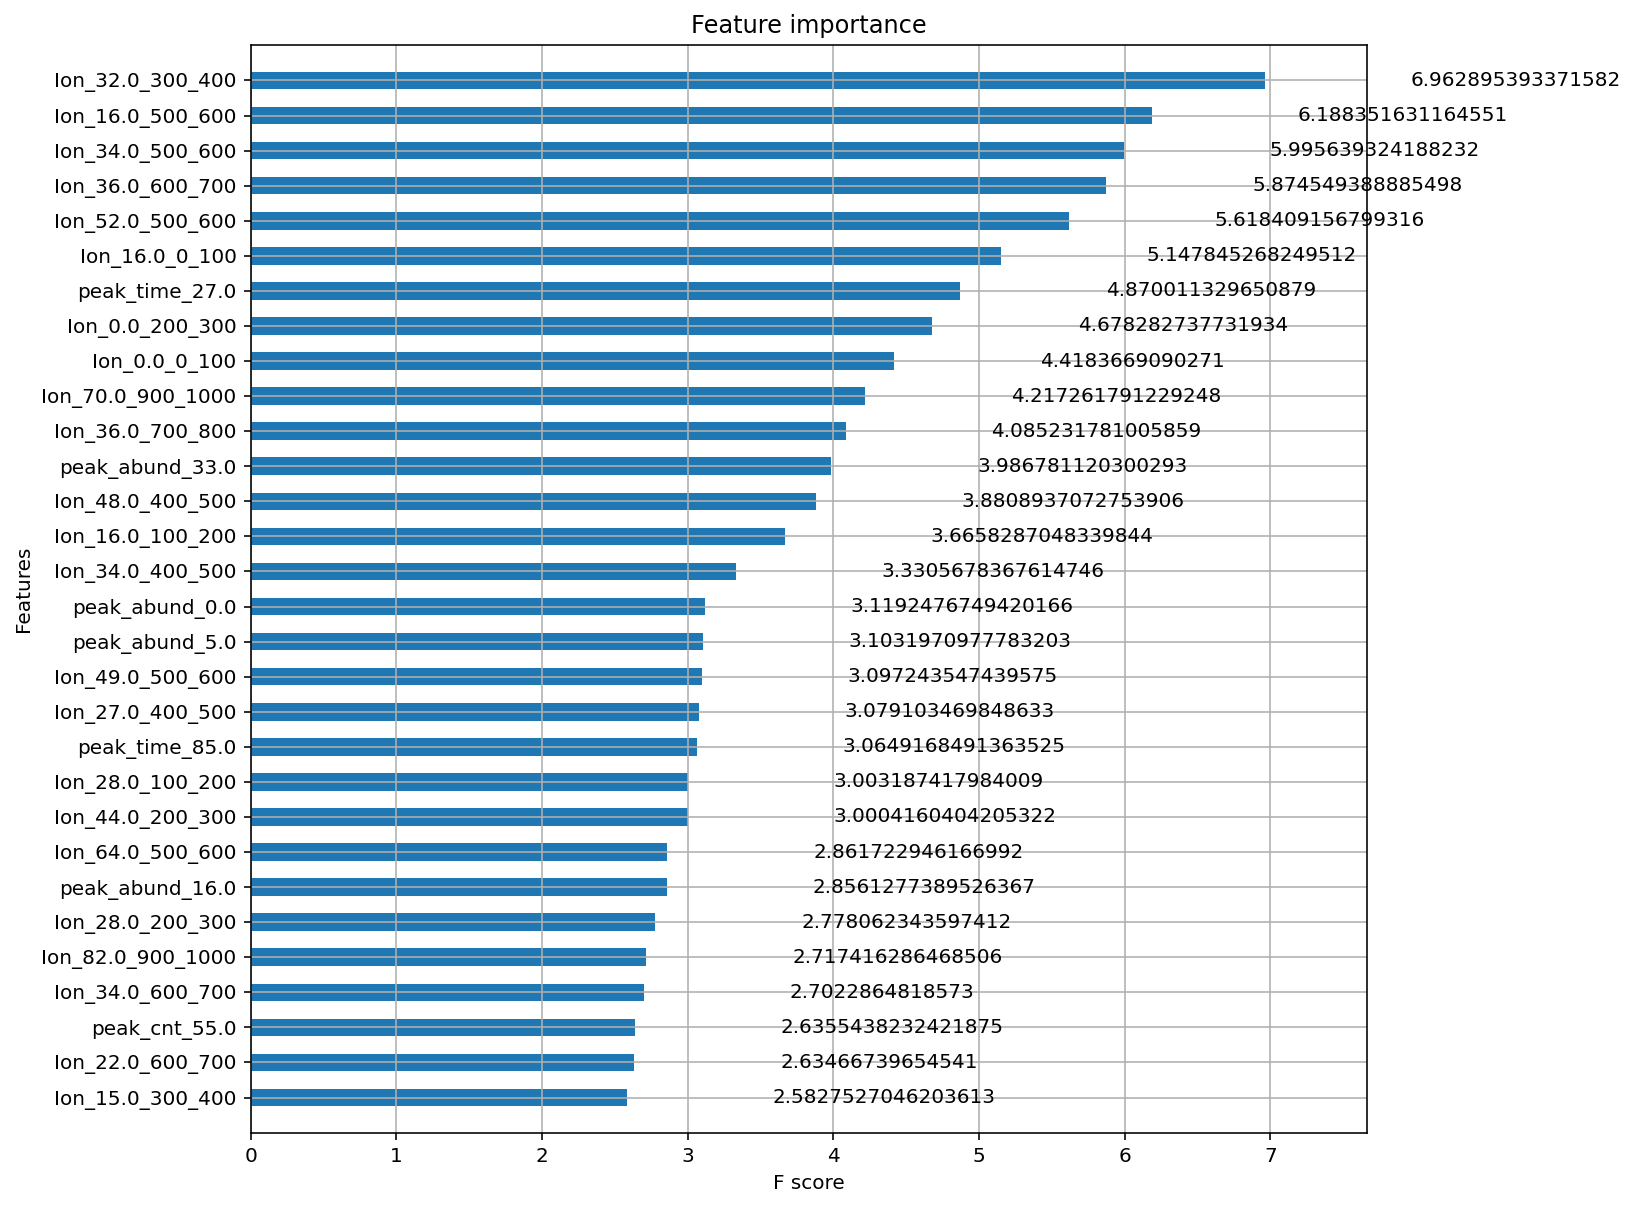

LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


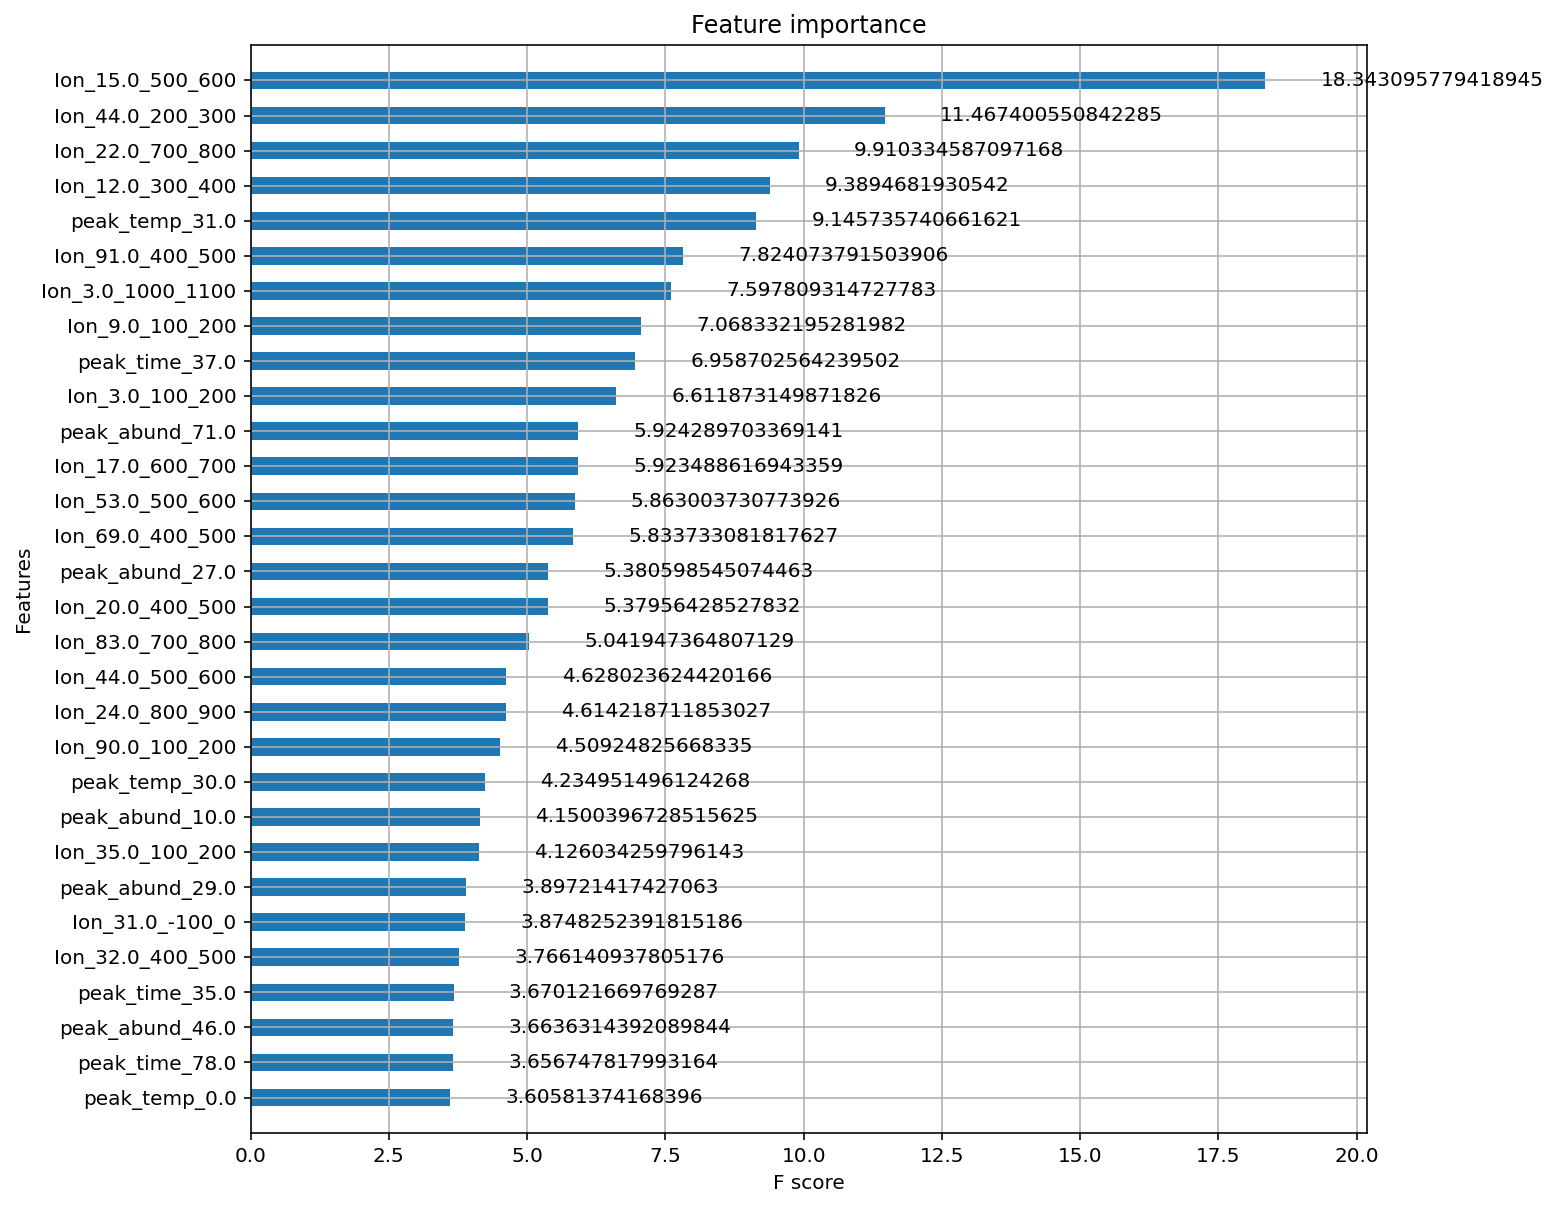

LABEL: oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


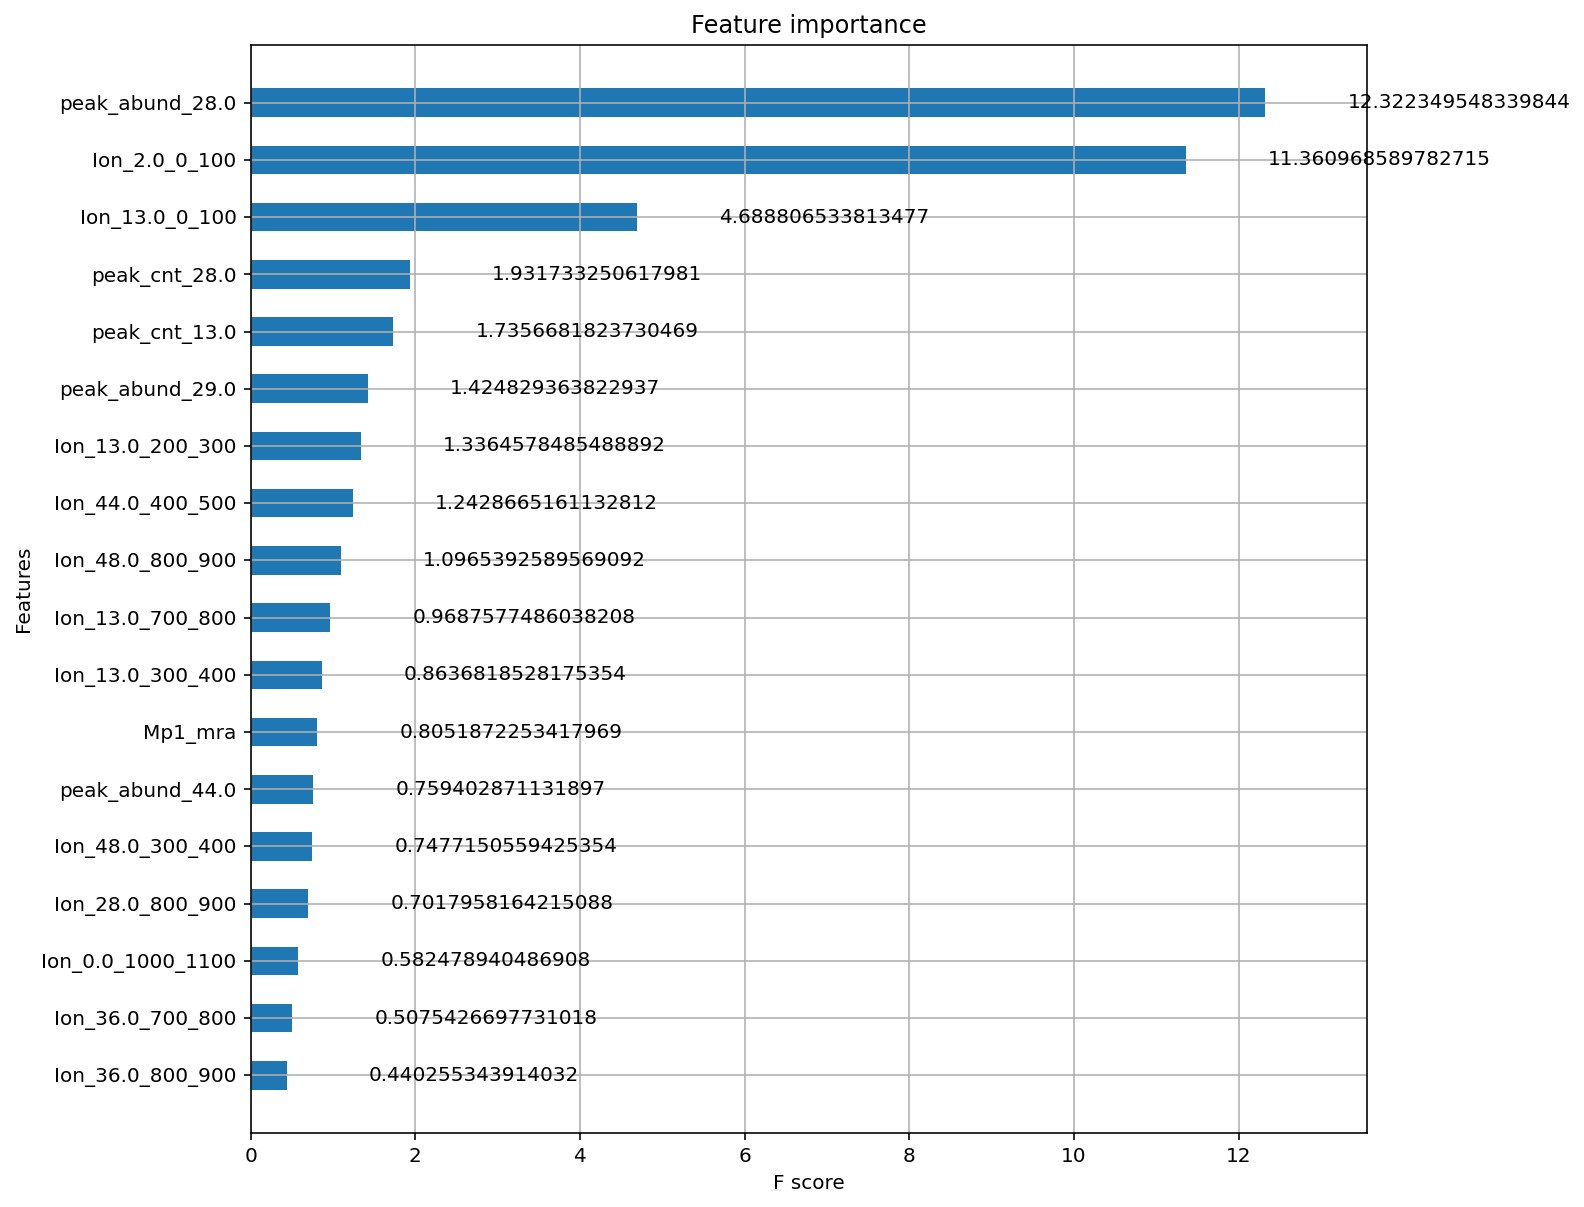

LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


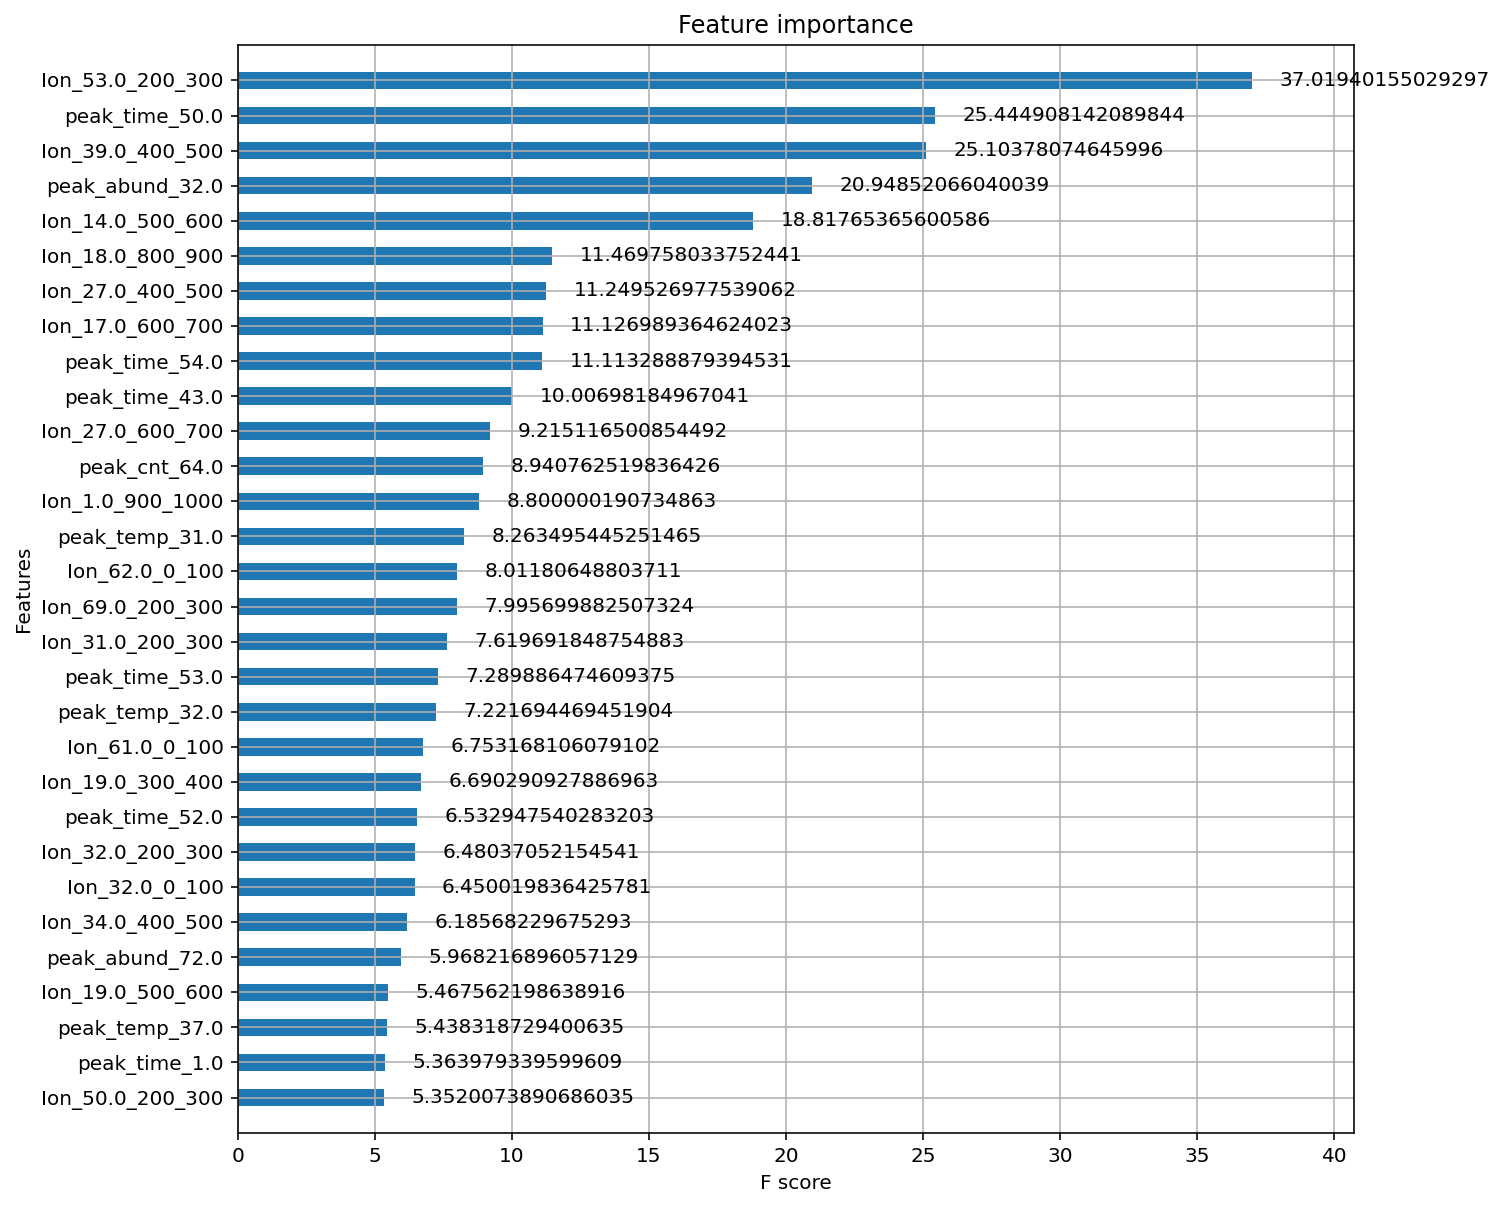

LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


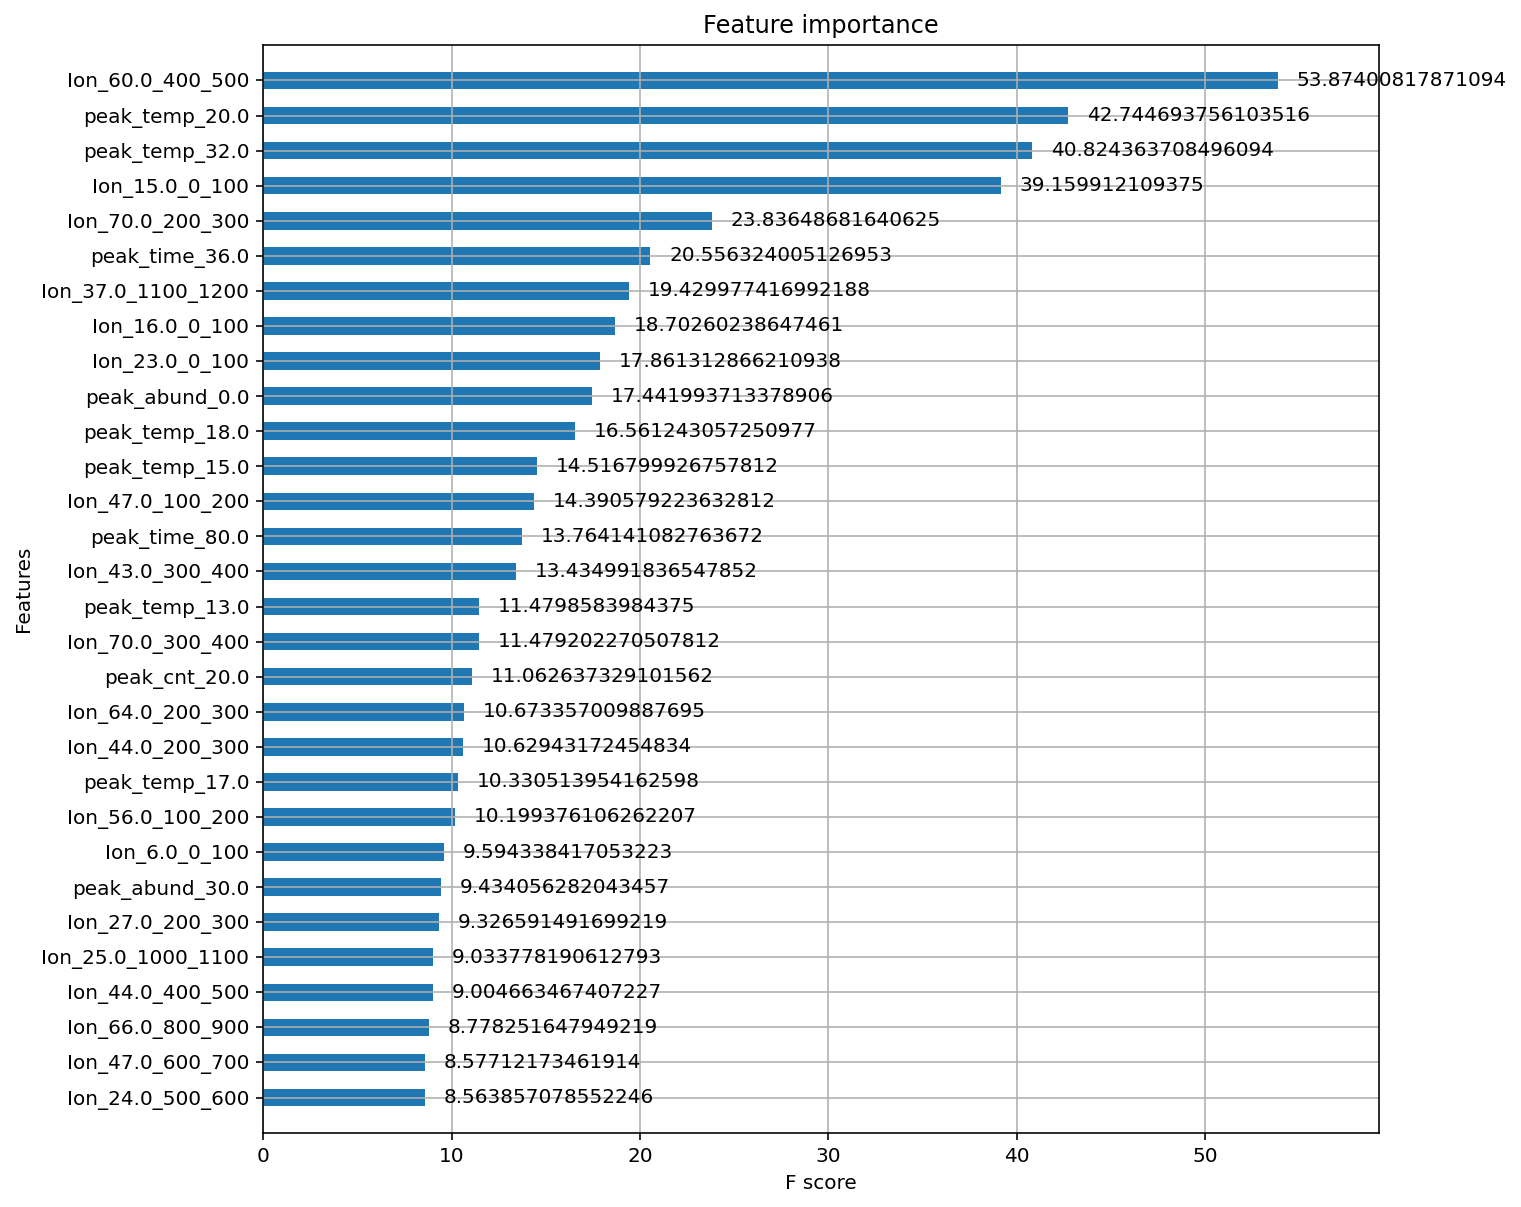

LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


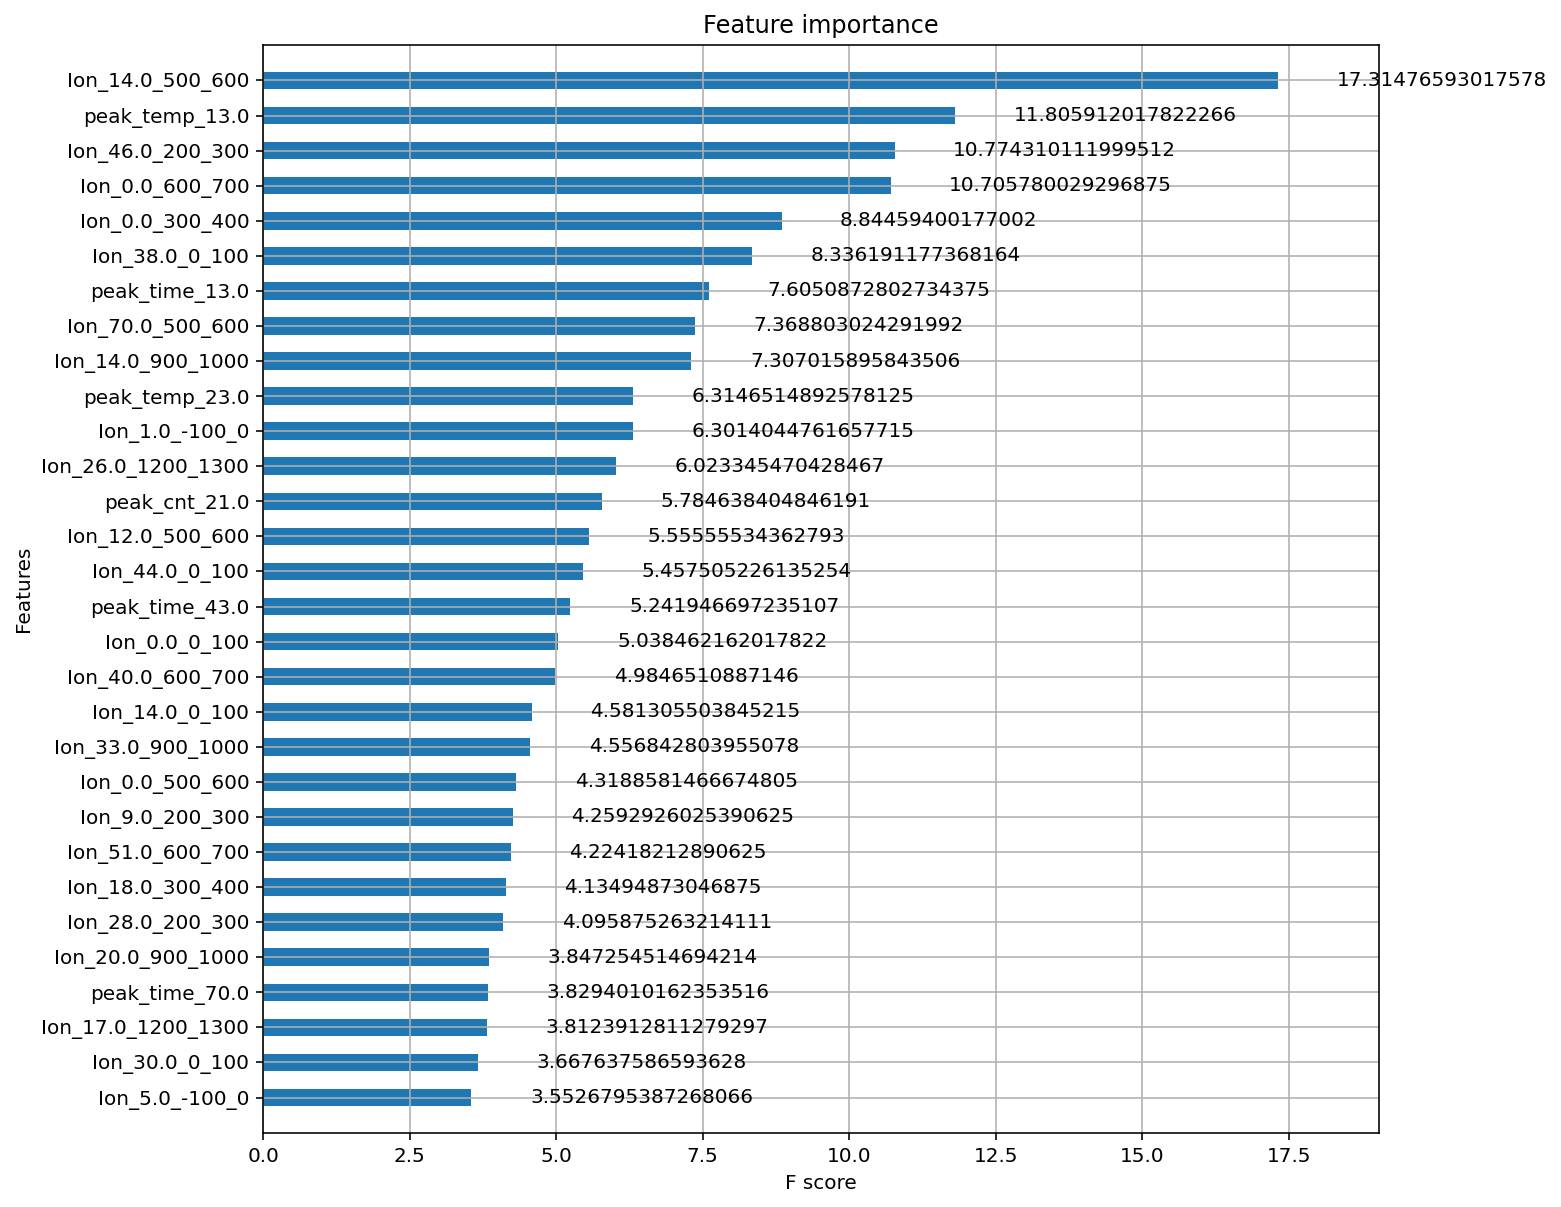

LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


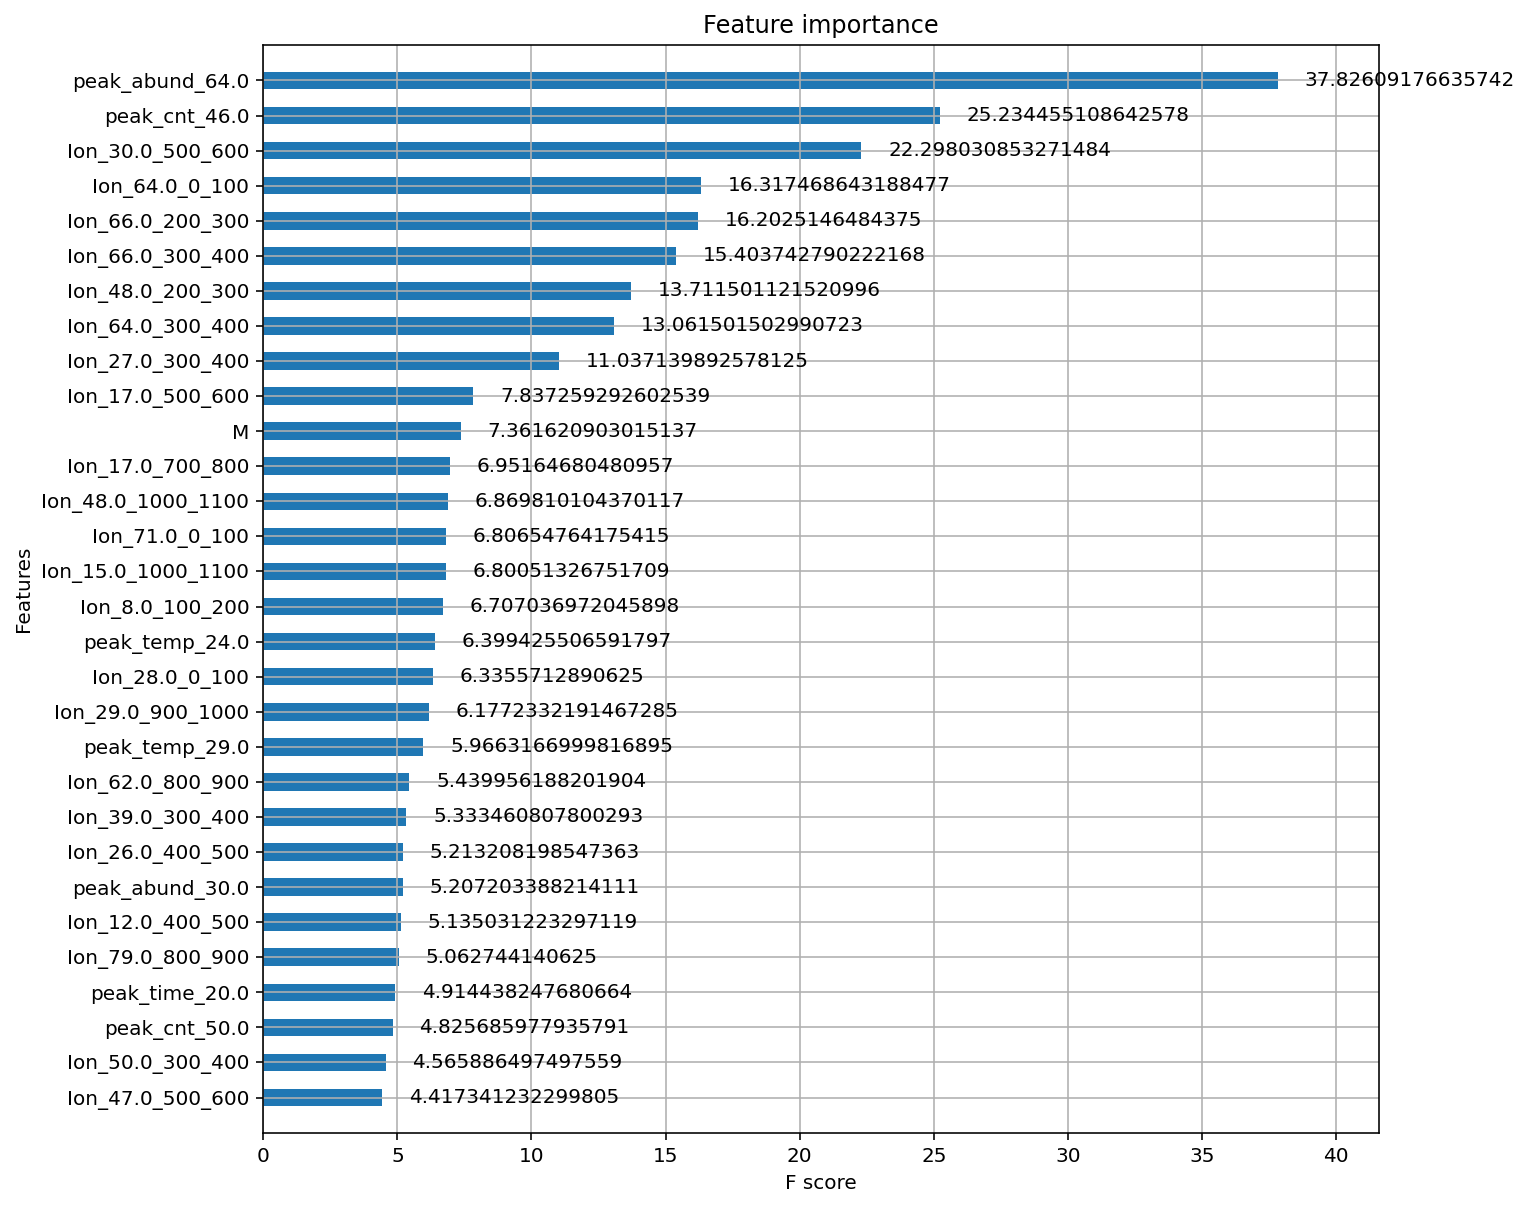

LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


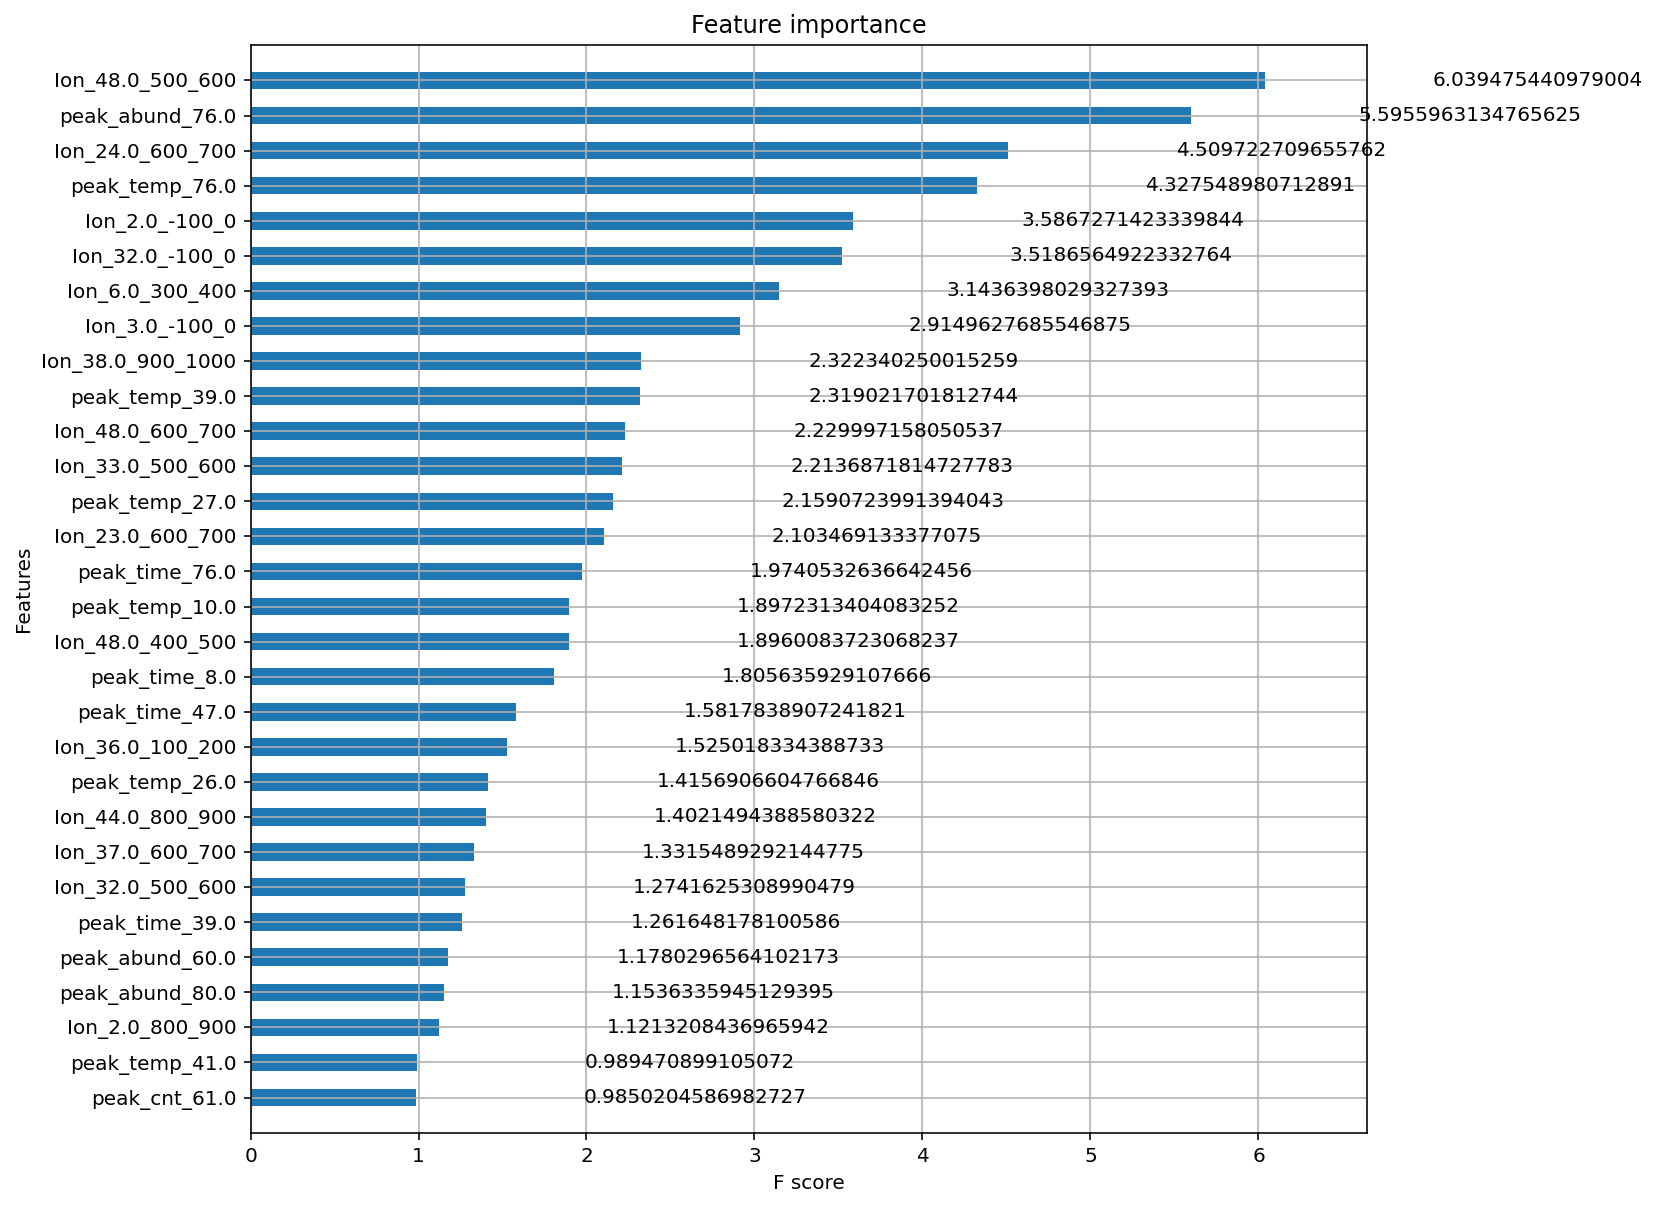


Average Log Loss: 0.1548
Log Loss per Label:
{'basalt': 0.14787643638480896, 'carbonate': 0.12361431972609915, 'chloride': 0.17835871351192956, 'iron_oxide': 0.23414320543591255, 'oxalate': 0.014486072301787317, 'oxychlorine': 0.1588819542286757, 'phyllosilicate': 0.23647077978903233, 'silicate': 0.18902406531295024, 'sulfate': 0.20727511739910104, 'sulfide': 0.05748256855398783}
(293, 10)


In [14]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_tr',
    fts_select_cols=SFM_COLUMNS,
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               valid_files, valid_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_tr',
                                               fts_select_cols=True)

In [15]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)

CV Logloss: 0.15476132326442846
VALID FM LogLoss: 0.15374808633853382
CV logLoss Label
{'basalt': 0.14787643638480896, 'carbonate': 0.12361431972609915, 'chloride': 0.17835871351192956, 'iron_oxide': 0.23414320543591255, 'oxalate': 0.014486072301787317, 'oxychlorine': 0.1588819542286757, 'phyllosilicate': 0.23647077978903233, 'silicate': 0.18902406531295024, 'sulfate': 0.20727511739910104, 'sulfide': 0.05748256855398783}


**TRAIN & VALID**

CV training ....
basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

Full training .....
LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


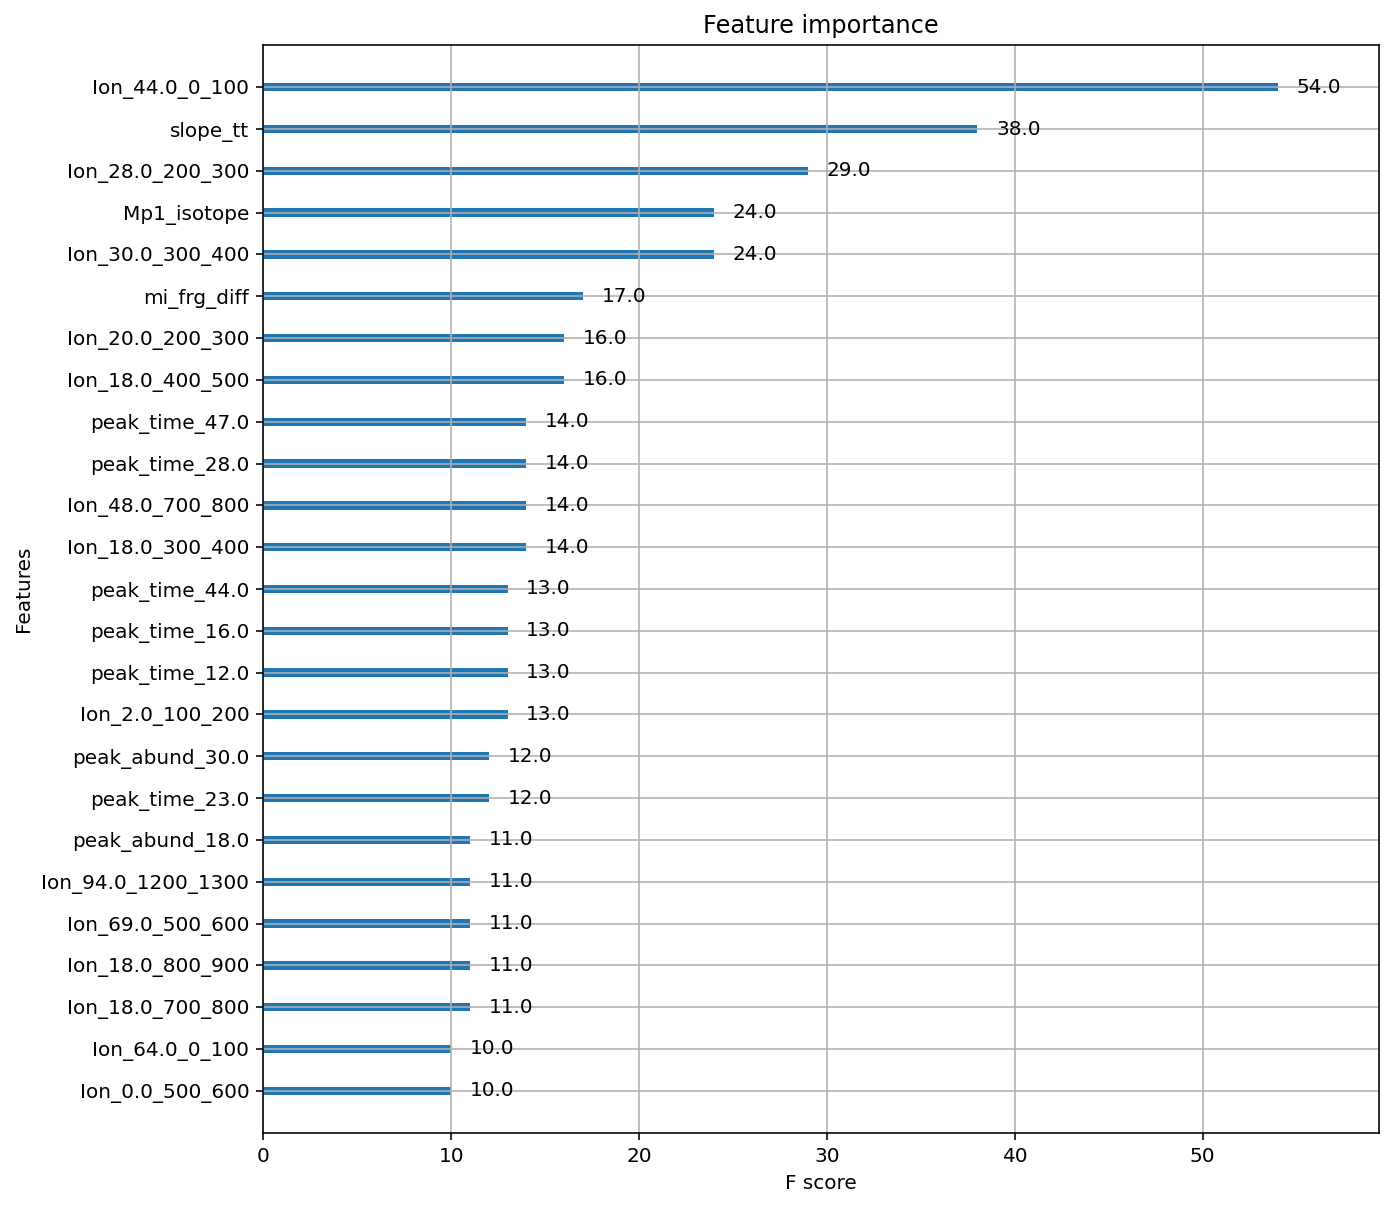

LABEL: carbonate


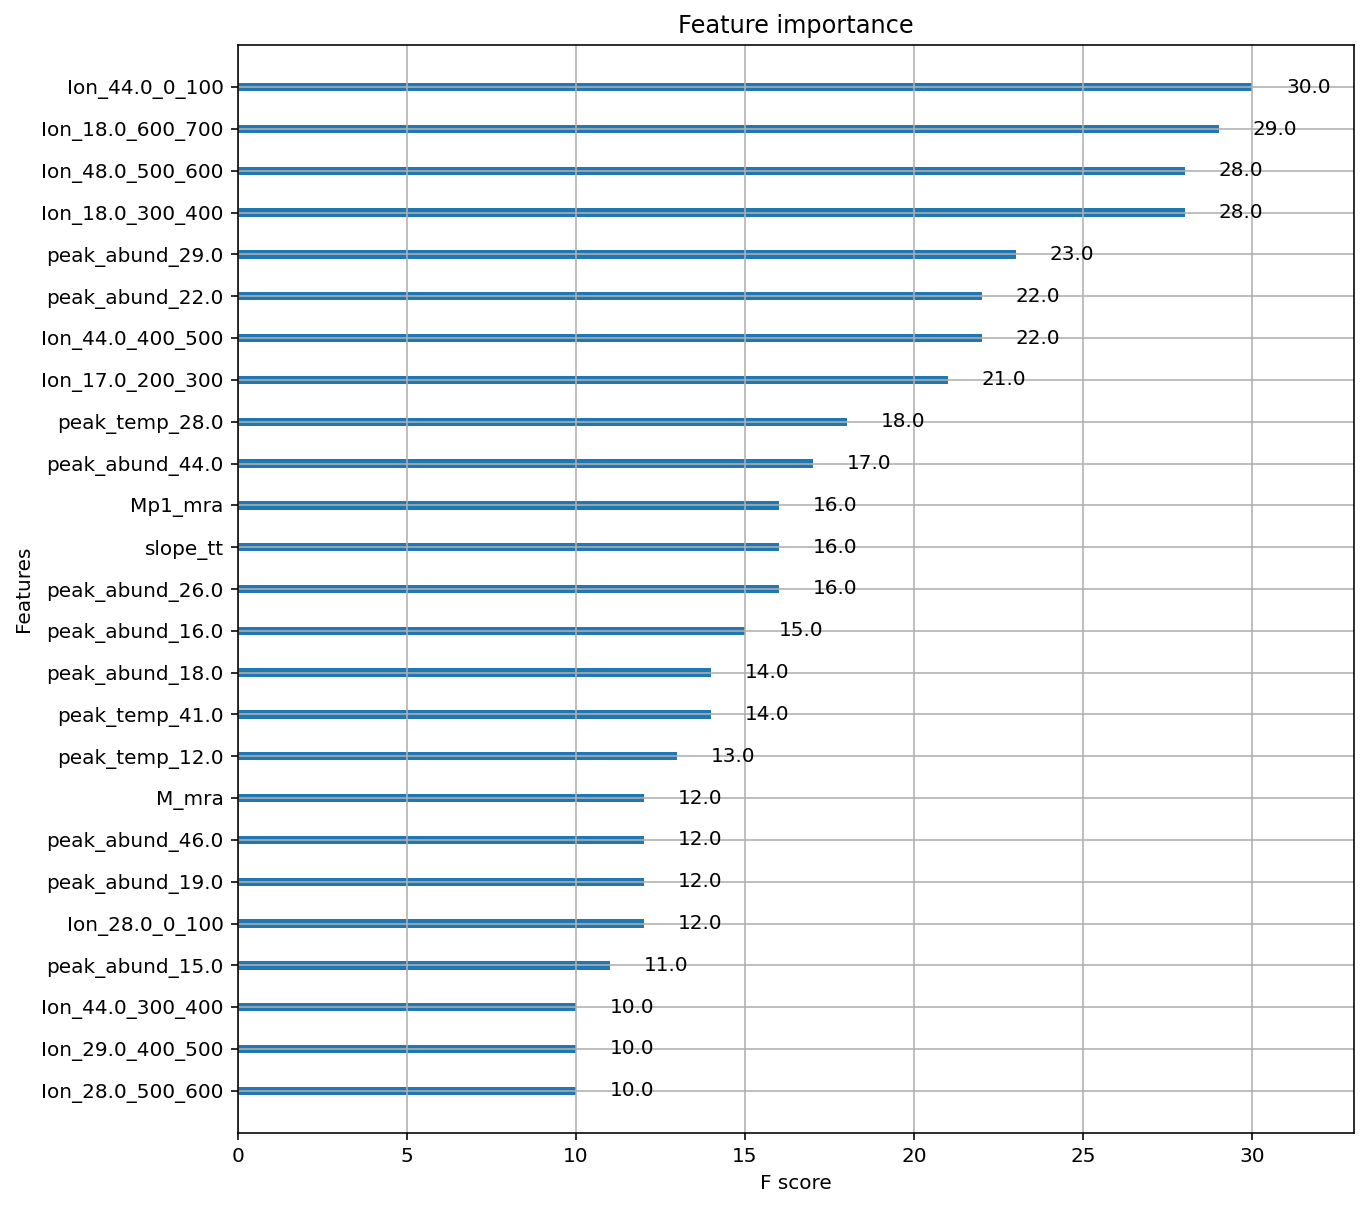

LABEL: chloride


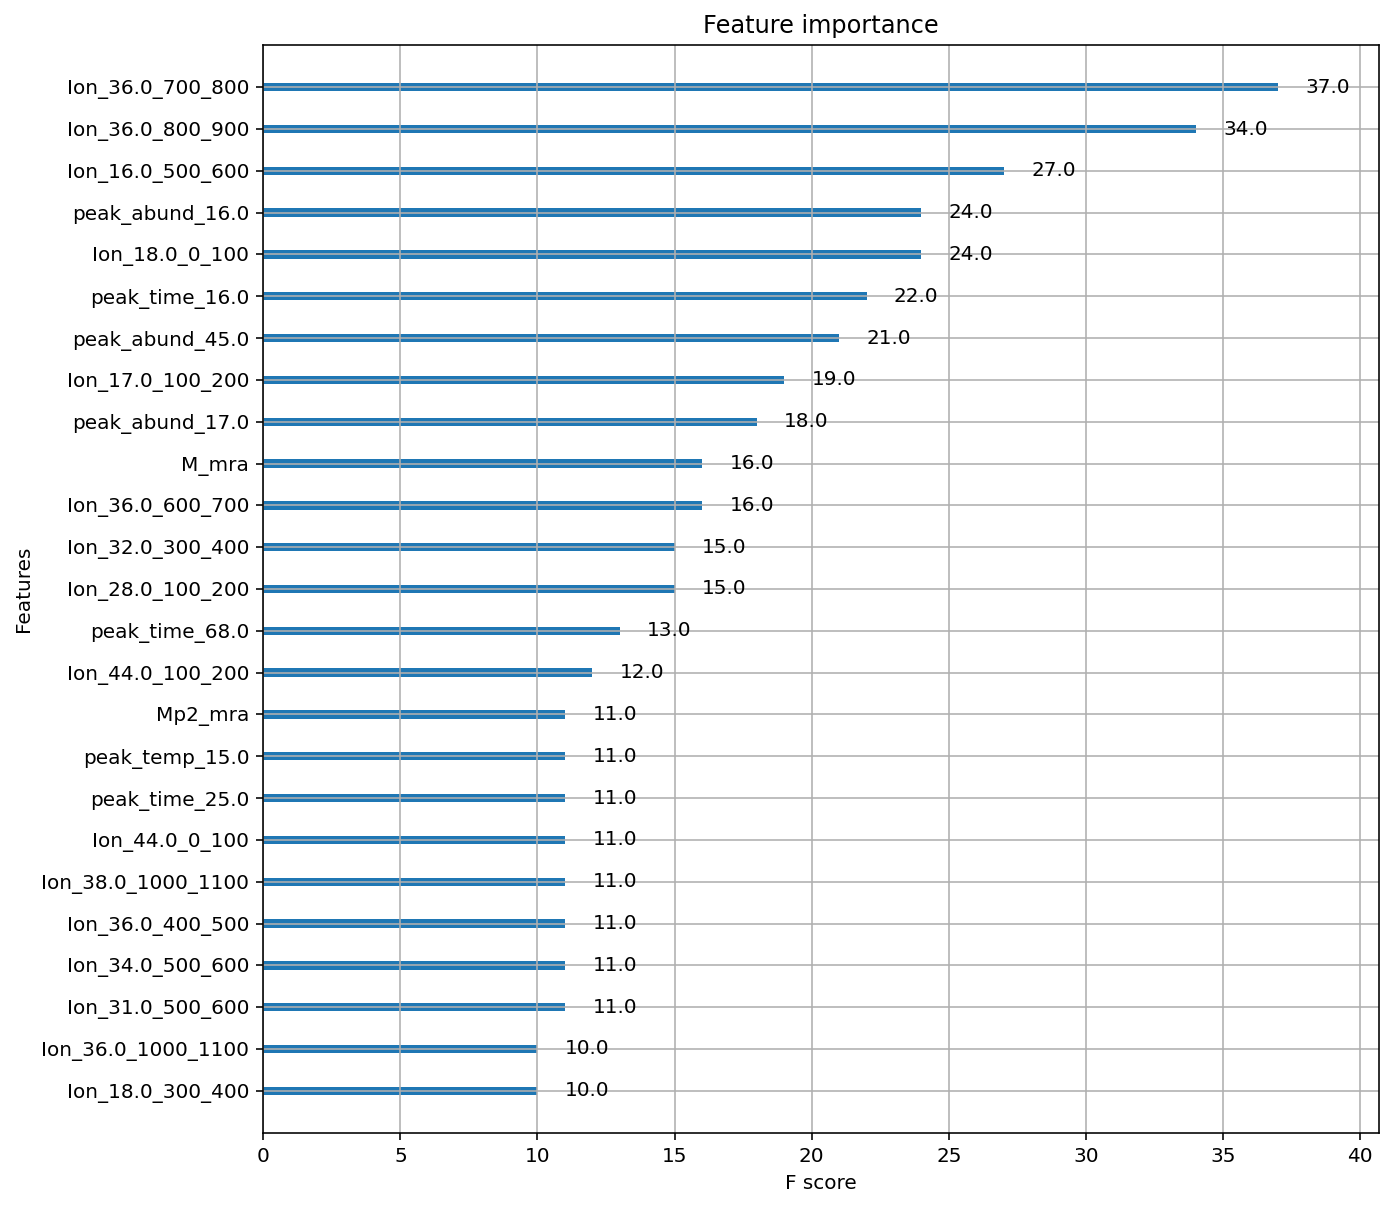

LABEL: iron_oxide


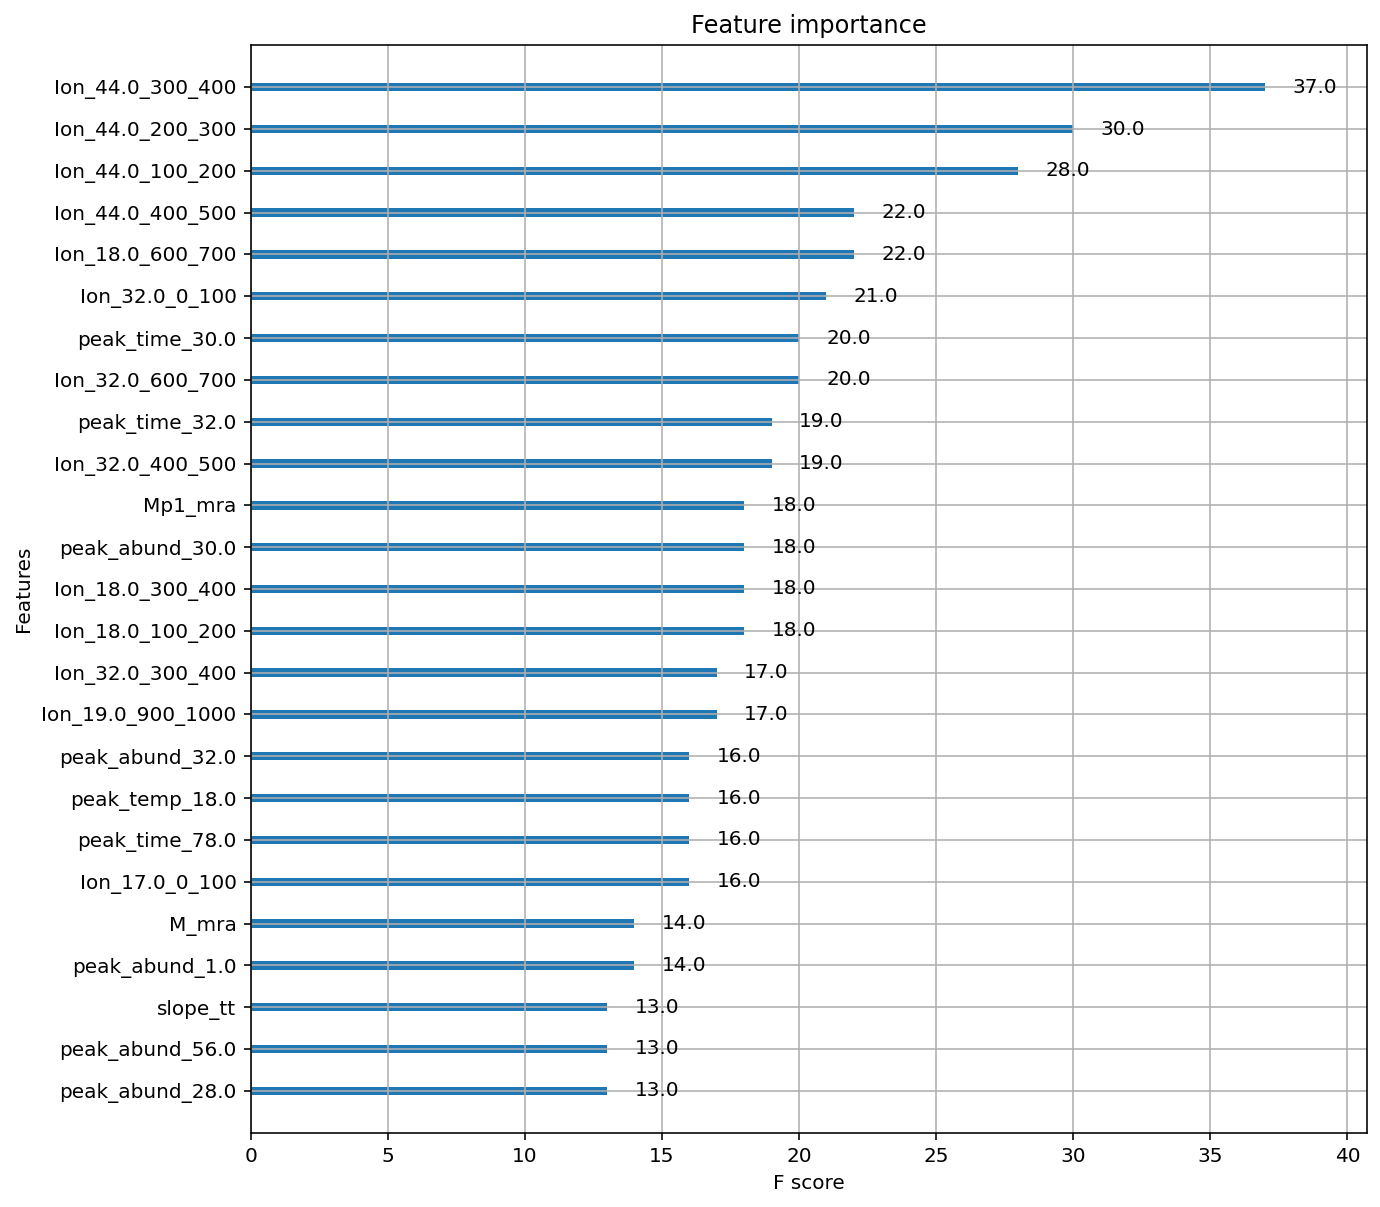

LABEL: oxalate


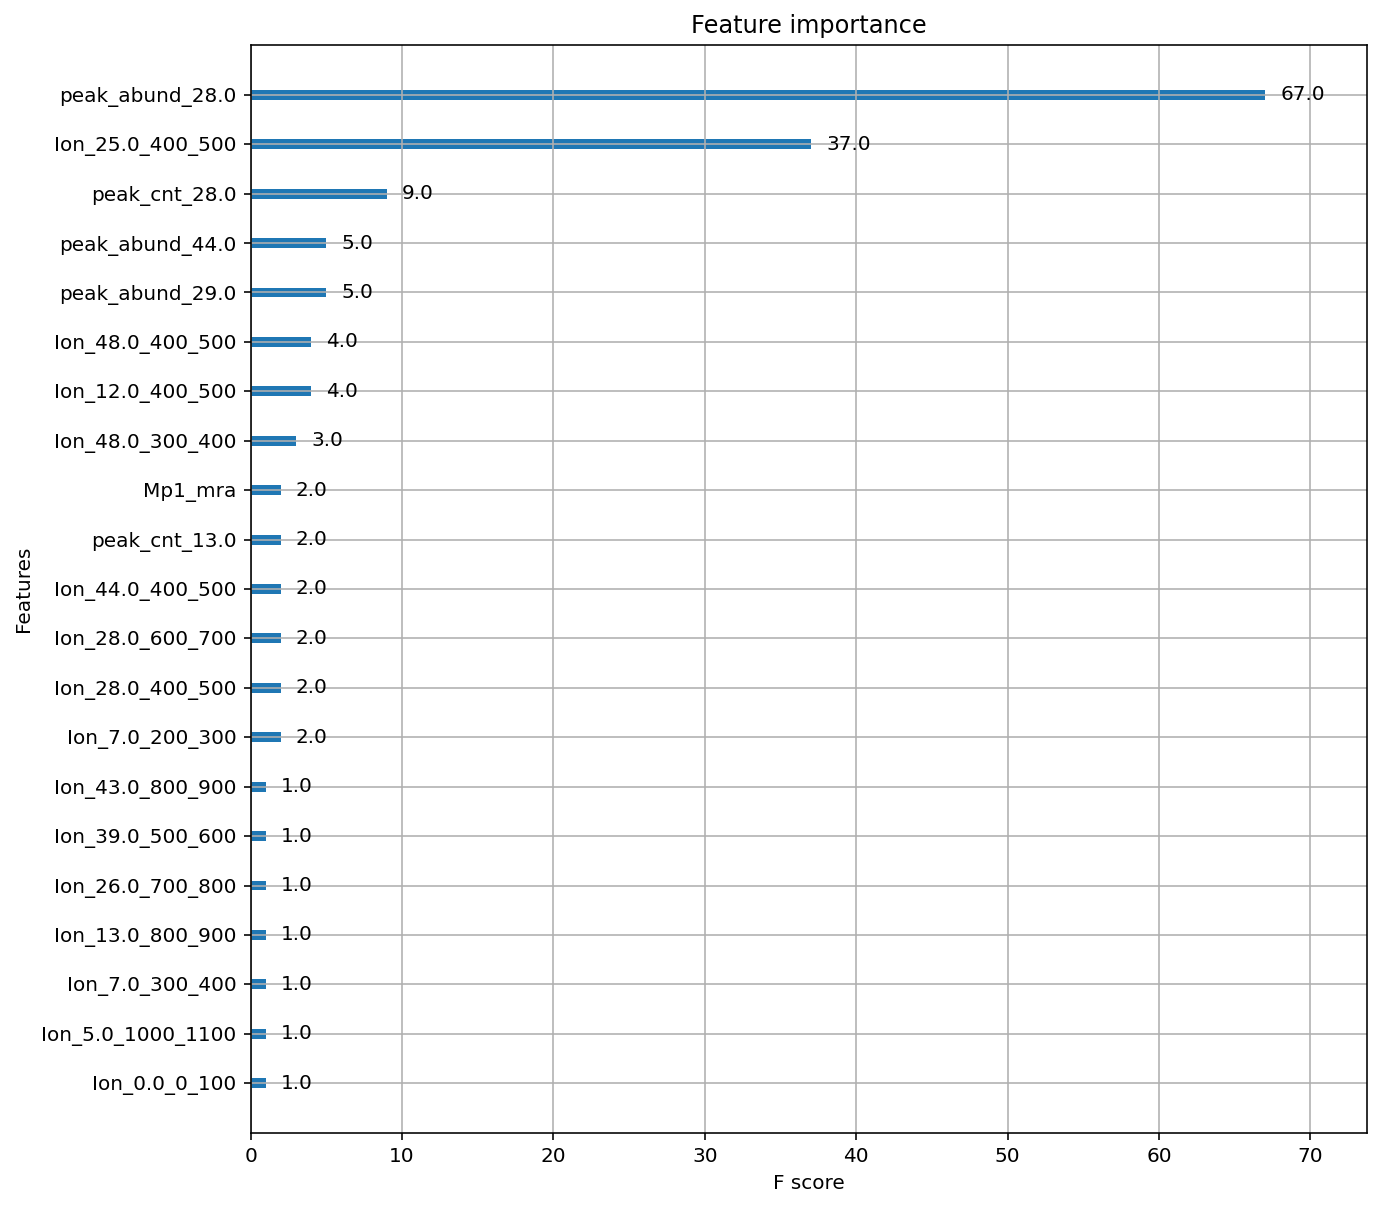

LABEL: oxychlorine


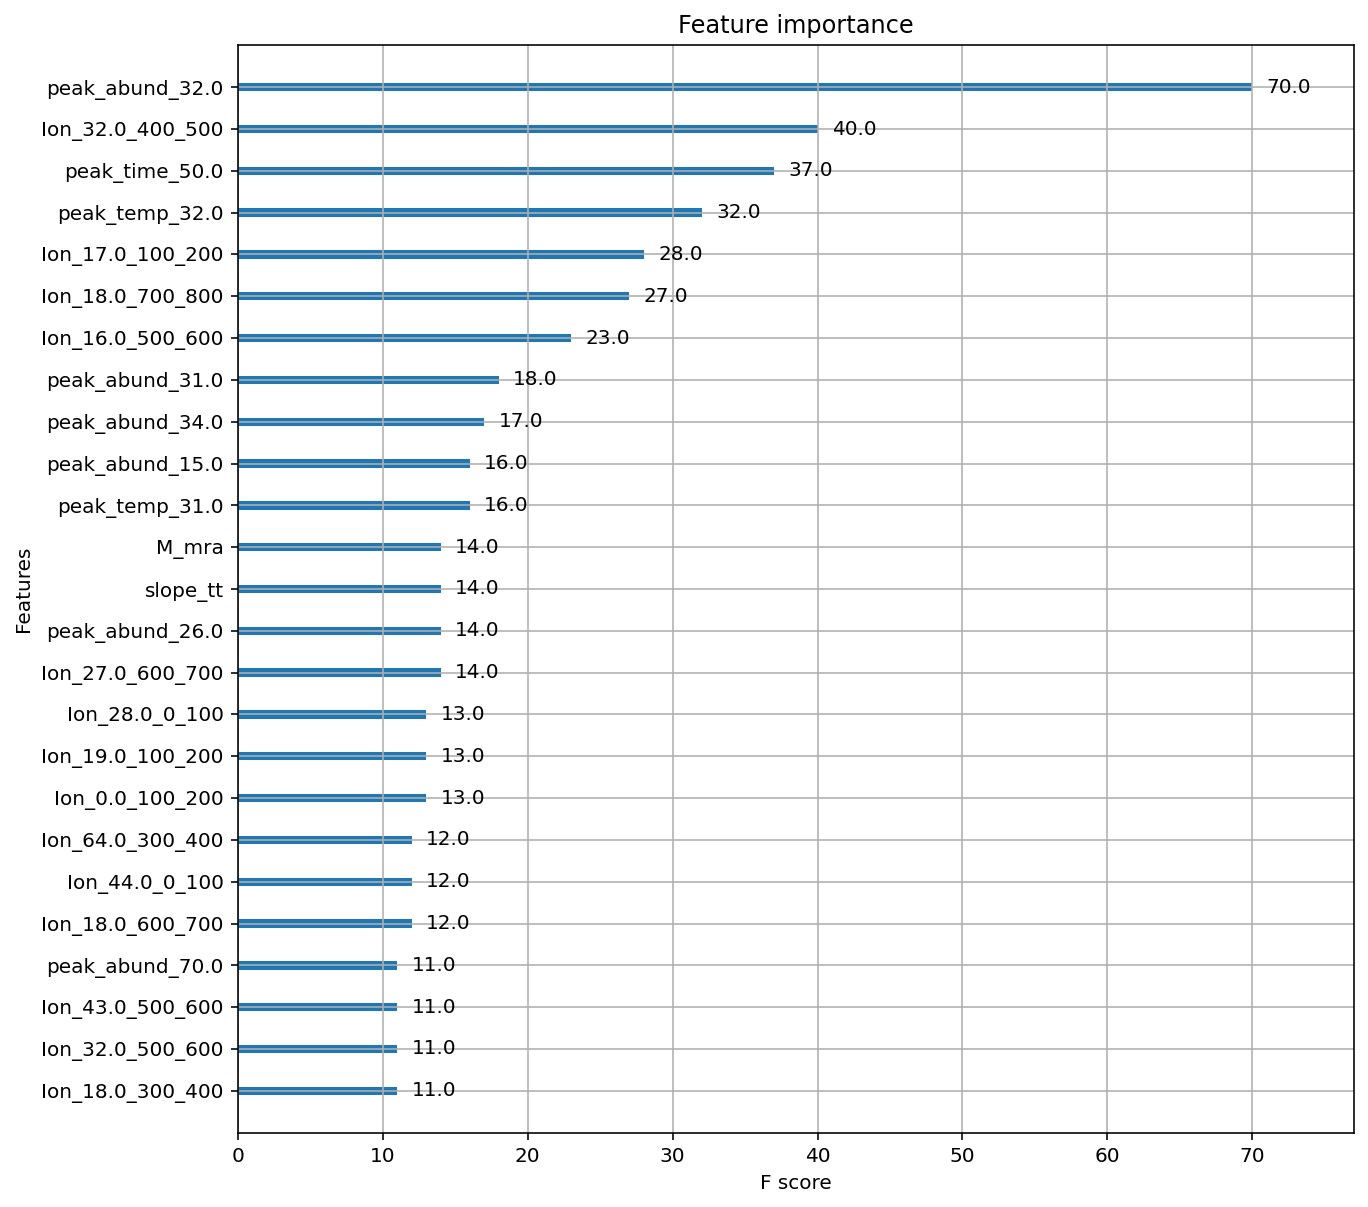

LABEL: phyllosilicate


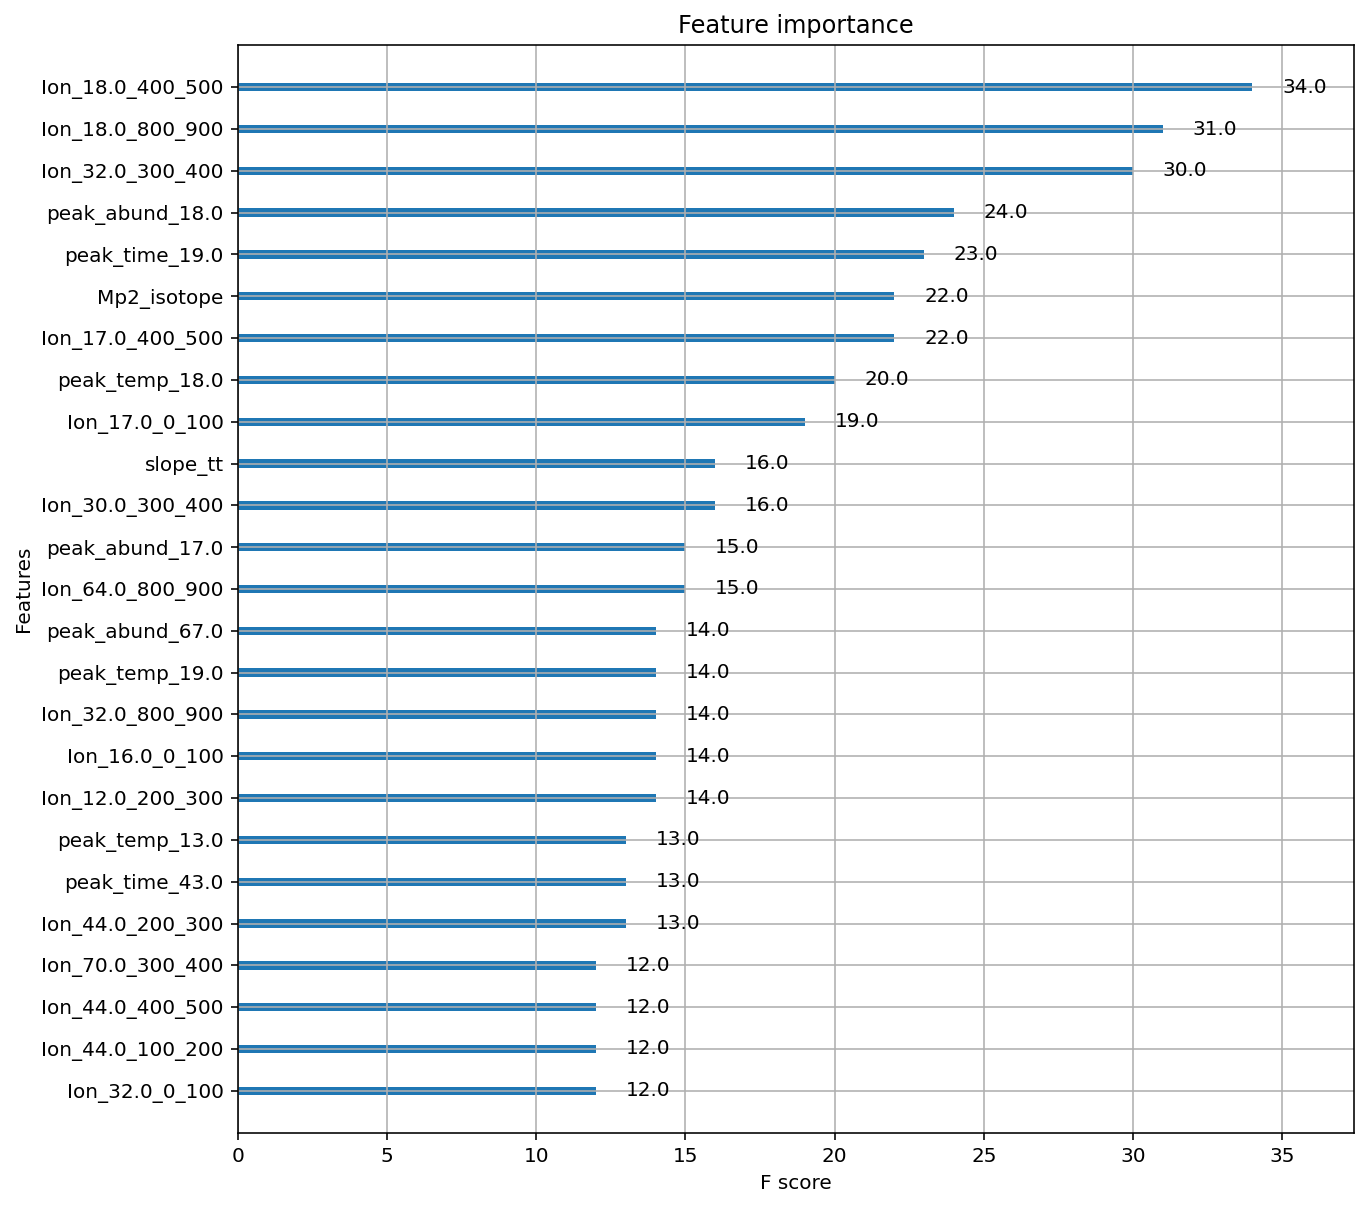

LABEL: silicate


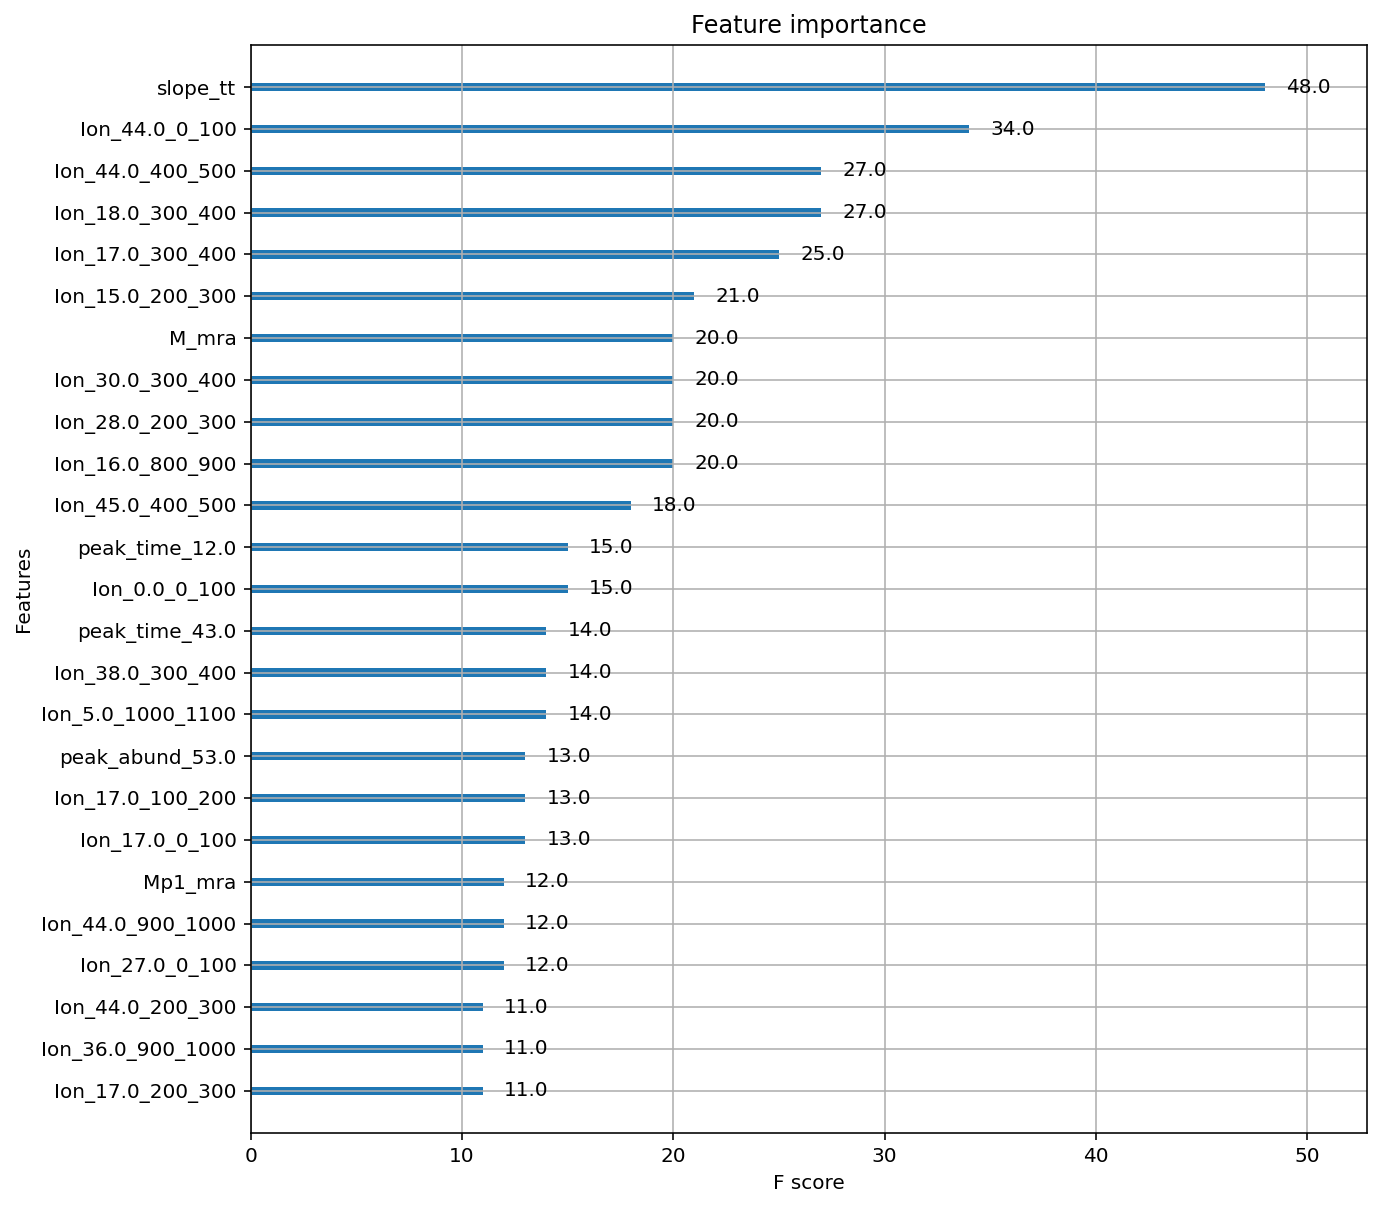

LABEL: sulfate


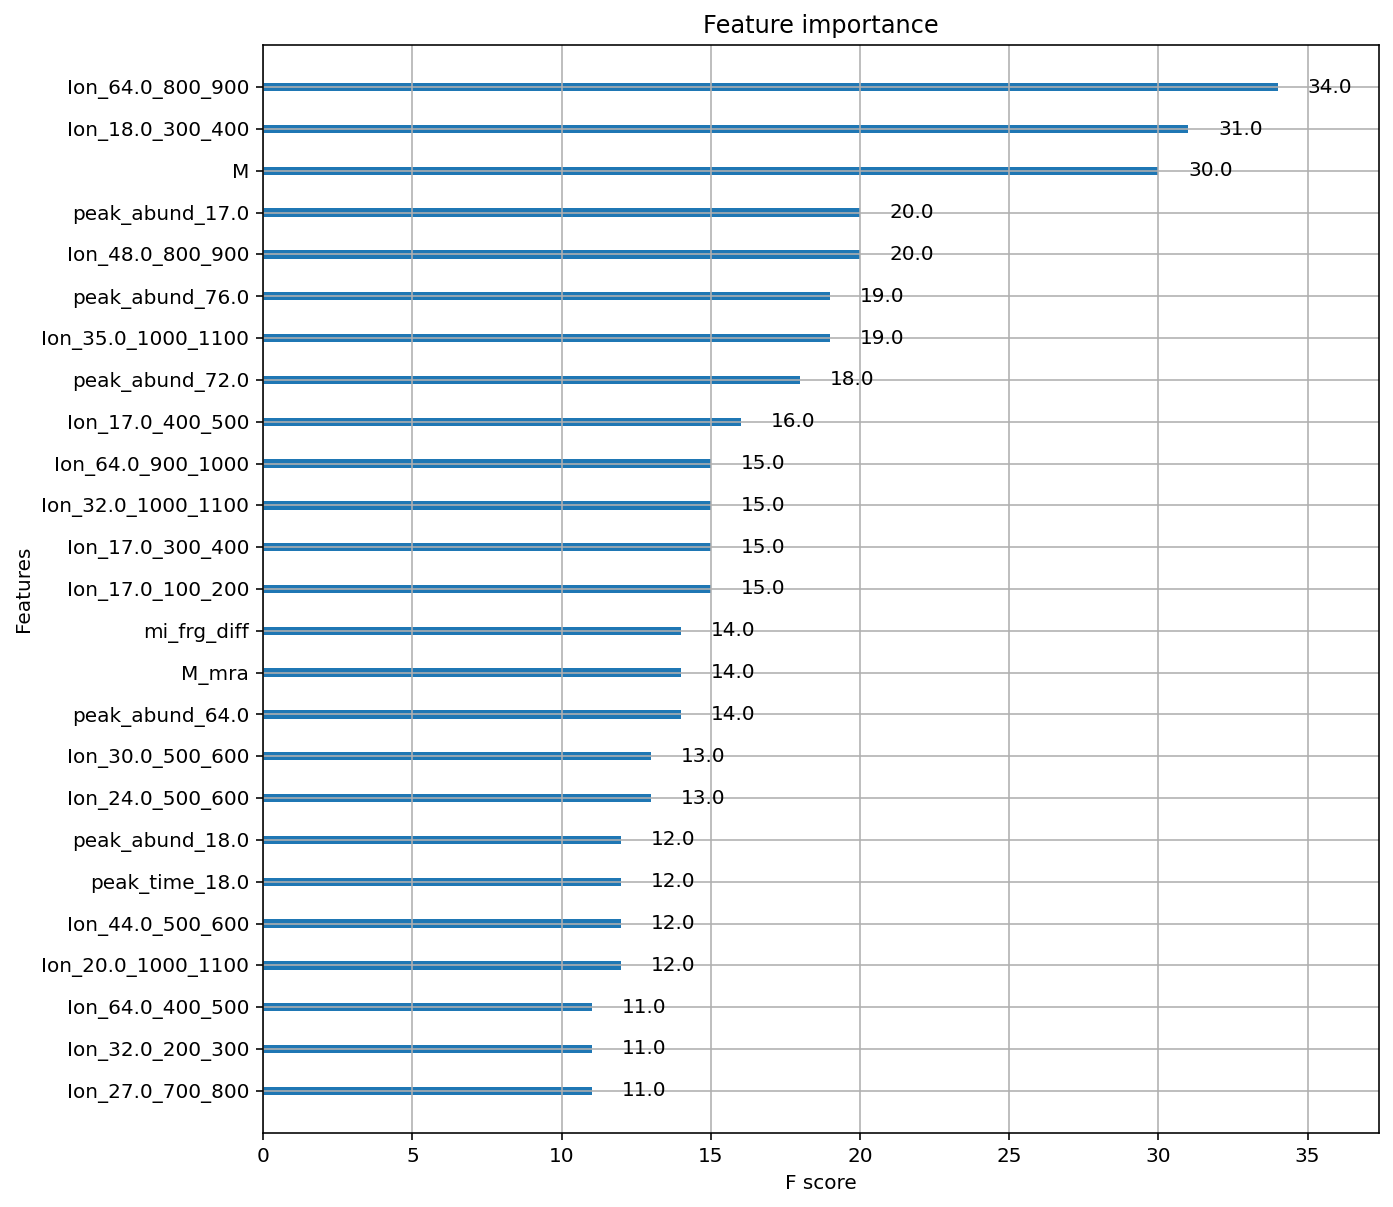

LABEL: sulfide


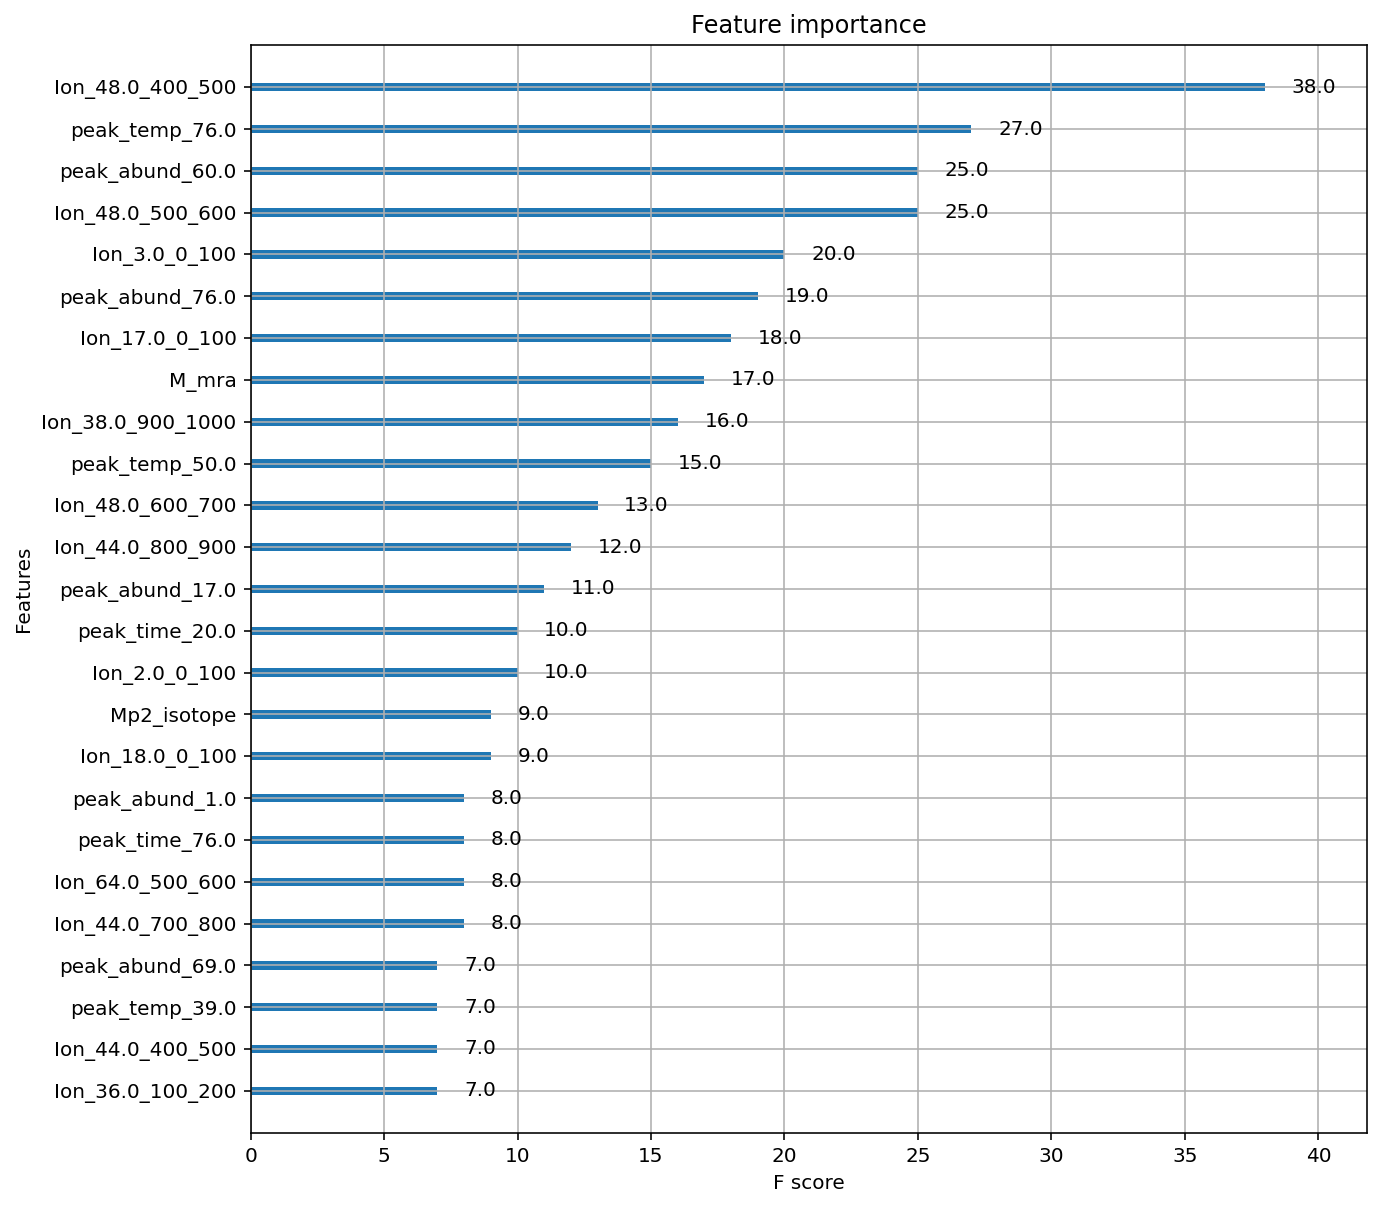


Average Log Loss: 0.1423
Log Loss per Label:
{'basalt': 0.14454150217684264, 'carbonate': 0.08635449306652845, 'chloride': 0.1692469494765426, 'iron_oxide': 0.2092332869874621, 'oxalate': 0.012537570247599838, 'oxychlorine': 0.1408598591270323, 'phyllosilicate': 0.2291803502641357, 'silicate': 0.18686892932007956, 'sulfate': 0.17470823987189277, 'sulfide': 0.06963498027163063}


In [16]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_trvl,
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_trvl'
    )

In [17]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'CV logLoss Label')
print(cvloss)

CV Logloss: 0.14231661608097465
CV logLoss Label
{'basalt': 0.14454150217684264, 'carbonate': 0.08635449306652845, 'chloride': 0.1692469494765426, 'iron_oxide': 0.2092332869874621, 'oxalate': 0.012537570247599838, 'oxychlorine': 0.1408598591270323, 'phyllosilicate': 0.2291803502641357, 'silicate': 0.18686892932007956, 'sulfate': 0.17470823987189277, 'sulfide': 0.06963498027163063}


**SAM TRAINING**

In [ ]:
# ===== TRAIN SAM =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr_sam,
    df_labels=sam_labels,
    target_list=target_labels_list,
    df_test=X_vl_sam,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_sam',
    test_sam=True
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               sam_files, sam_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_sam')

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)